In [1]:
import os, sys
import numpy as np
import pickle
import uproot
import glob
import pandas as pd
from tqdm import tqdm
import json
import ROOT as rt
import fnmatch

## user define
sys.path.append('.')
sys.path.append('./Utils')
from Plotter import HistStack

from beeps import *

Welcome to JupyROOT 6.26/08


# Set config

In [2]:
# ERA="ee17"
# ERA="ee16pre"
# # ERA="mm18"
# ERA="em18"
# # DATE = '20230129_17_eleffmva'
# DATE = '20230301_18'
# # DATE = '20230130_18_dyhighworctight'
# # INPUTDIR = "/eos/user/h/hkwon/Run2/20230130_18_dyhighworctight/mm/"
# INPUTDIR = "/eos/user/h/hkwon/Run2/20230301_18/em/"
import sys
ERA = sys.argv[1]
DATE = sys.argv[2]
INPUTDIR = sys.argv[3]

DUMP_PKL = True
DRAW_SR = True
RUN_SIDEBAND_MET = True
RUN_SIDEBAND_MASS = True
RUN_SIDEBAND_PT = True
DUMP_SIDEBAND_MET_PKL = True
DUMP_SIDEBAND_MASS_PKL = True
DUMP_SIDEBAND_PT_PKL = True
RUN_BTAG = False
EXPORT_VARIABLE = False

# # for dev
# ERA="ee16pre"
# DATE = '20230427wp80_16pre'
# INPUTDIR = "/eos/user/h/hkwon/Run2/"+DATE+"/ee/"


# Get input

In [3]:
lumi_all={
    "ee16pre":19520,
    "ee16post":16810,
    "ee17":41480,
    "ee18":59830,
    "mm16pre":19520,
    "mm16post":16810,
    "mm17":41480,
    "mm18":59830,    
#     "mm18":14000,    
    "em16pre":19520,
    "em16post":16810,
    "em17":41480,
    "em18":59830     
}

data_evts = {
    "ee16pre":652566543,
    "ee16post":287977113,
    "ee17":460041183,
    "ee18":1326465857,
    "mm16pre":458655573,
    "mm16post":327037312,
    "mm17":739073837,
#     "mm18":944842550,  #949352777 
    "mm18":949352777,  #949352777 
    "em16pre":1111222116,
    "em16post":615014425,
    "em17":1199115020,
#     "em18":2271308407   #2281001366  
    "em18":2281001366   #2281001366  
}

lumi=lumi_all[ERA]
print(ERA, lumi)

channel = ERA.replace("16pre", "")
channel = channel.replace("16post", "")
channel = channel.replace("17", "")
channel = channel.replace("18", "")

def get_df(root_file_name, unneccesary_columns):
    f = uproot.open(root_file_name)
    df = uproot.open(root_file_name)["Events_"+channel].arrays(library="pd")
    df_met_u = uproot.open(root_file_name)["Events_"+channel+"_met_u"].arrays(library="pd")
    df_met_d = uproot.open(root_file_name)["Events_"+channel+"_met_d"].arrays(library="pd")    
#     df_scale_u = uproot.open(root_file_name)["Events_"+channel+"_scale_u"].arrays(library="pd")
#     df_scale_d = uproot.open(root_file_name)["Events_"+channel+"_scale_d"].arrays(library="pd")
    info = uproot.open(root_file_name)["Info_"+channel].arrays(library="pd")
#     return sum(info["sumweight"]), df.drop(unneccesary_columns, axis=1), df_met_u.drop(unneccesary_columns, axis=1), df_met_d.drop(unneccesary_columns, axis=1), df_scale_u.drop(unneccesary_columns, axis=1), df_scale_d.drop(unneccesary_columns, axis=1)
    return sum(info["sumweight"]), df.drop(unneccesary_columns, axis=1), df_met_u.drop(unneccesary_columns, axis=1), df_met_d.drop(unneccesary_columns, axis=1)

unneccesary_columns = []
dic_input = {
    "ee16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/ee/",
    "mm16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/mm/",
    "em16pre": "/eos/user/h/hkwon/Run2/"+DATE+"_16pre/em/",
    "ee16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/ee/",
    "mm16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/mm/",
    "em16post": "/eos/user/h/hkwon/Run2/"+DATE+"_16post/em/",
    "ee17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/ee/",
    "mm17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/mm/",
    "em17": "/eos/user/h/hkwon/Run2/"+DATE+"_17/em/",
    "ee18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/ee/",
    "mm18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/mm/",    
    "em18": "/eos/user/h/hkwon/Run2/"+DATE+"_18/em/"        
#     "em18": "/eos/user/h/hkwon/Run2/20221120_18/em/"        
}
# input_dir = dic_input[ERA]
input_dir = INPUTDIR
f = []
for (dirpath, dirnames, filenames) in os.walk(input_dir):
    f.extend(filenames)
    break

dic_tup={}
for file in tqdm(f):
    # file naming: flatNtuple_Preselect_WZ1.root, flatNtuple_Preselect_Zp-3700_CH-1345.root
    if not "flatNtuple" in file:
        continue
#     if channel=="mm" and (fnmatch.fnmatch(file, '*E*Run*') or fnmatch.fnmatch(file, '*M*RunB*') or fnmatch.fnmatch(file, '*M*RunC*') or fnmatch.fnmatch(file, '*M*RunD*')): #temp
    if channel=="mm" and fnmatch.fnmatch(file, '*E*Run*'): #temp
        continue
    if channel=="ee" and fnmatch.fnmatch(file, '*M*Run*'):
        continue
#     if channel=="em" and fnmatch.fnmatch(file, '*E*Run*'):
#         continue  

    if "Zp" in file:
        sample=file.split('_')[2]+"_"+file.split('_')[3]
    else:
        sample=file.split('_')[2]
    sample=sample.rstrip('.root')
    try:
        print(sample)
        dic_tup[sample]=get_df(input_dir+file, unneccesary_columns)   
    except:
        print(sample)
        beep()        
        if "Run" in sample: # check file corrupt
            raise    
# dic_tup

ee16pre 19520


  0%|          | 0/147 [00:00<?, ?it/s]

DY0


  1%|          | 1/147 [00:00<01:23,  1.74it/s]

DY1


  1%|▏         | 2/147 [00:01<01:20,  1.81it/s]

DY1000To15000


  2%|▏         | 3/147 [00:01<01:09,  2.07it/s]

DY1000To15001


  3%|▎         | 4/147 [00:01<01:03,  2.26it/s]

DY1000To15002


  3%|▎         | 5/147 [00:02<00:57,  2.45it/s]

DY1000To15003


  4%|▍         | 6/147 [00:02<00:54,  2.58it/s]

DY1500To20000


  5%|▍         | 7/147 [00:03<00:56,  2.47it/s]

DY2


  5%|▌         | 8/147 [00:03<01:03,  2.18it/s]

DY2000To30000


  6%|▌         | 9/147 [00:04<01:01,  2.24it/s]

DY2000To30001


  7%|▋         | 10/147 [00:04<00:58,  2.35it/s]

DY3


  7%|▋         | 11/147 [00:04<01:02,  2.18it/s]

DY4


  8%|▊         | 12/147 [00:05<01:03,  2.12it/s]

DY5


  9%|▉         | 13/147 [00:06<01:07,  1.99it/s]

DY500To7000


 10%|▉         | 14/147 [00:06<01:05,  2.03it/s]

DY6


 10%|█         | 15/147 [00:06<00:59,  2.20it/s]

DY700To8000


 11%|█         | 16/147 [00:07<00:58,  2.23it/s]

DY700To8001


 12%|█▏        | 17/147 [00:07<00:58,  2.24it/s]

DY800To10000


 12%|█▏        | 18/147 [00:08<00:57,  2.25it/s]

E16RunBver20


 13%|█▎        | 19/147 [00:08<00:53,  2.40it/s]

E16RunBver21


 14%|█▎        | 20/147 [00:08<00:50,  2.50it/s]

E16RunBver210


 14%|█▍        | 21/147 [00:09<00:48,  2.59it/s]

E16RunBver22


 15%|█▍        | 22/147 [00:09<00:47,  2.61it/s]

E16RunBver23


 16%|█▌        | 23/147 [00:09<00:46,  2.64it/s]

E16RunBver24


 16%|█▋        | 24/147 [00:10<00:47,  2.61it/s]

E16RunBver25


 17%|█▋        | 25/147 [00:10<00:46,  2.63it/s]

E16RunBver26


 18%|█▊        | 26/147 [00:11<00:44,  2.69it/s]

E16RunBver27


 18%|█▊        | 27/147 [00:11<00:45,  2.66it/s]

E16RunBver28


 19%|█▉        | 28/147 [00:11<00:44,  2.68it/s]

E16RunBver29


 20%|█▉        | 29/147 [00:12<00:43,  2.71it/s]

E16RunC0


 20%|██        | 30/147 [00:12<00:43,  2.70it/s]

E16RunC1


 21%|██        | 31/147 [00:12<00:42,  2.75it/s]

E16RunC2


 22%|██▏       | 32/147 [00:13<00:41,  2.77it/s]

E16RunC3


 22%|██▏       | 33/147 [00:13<00:40,  2.82it/s]

E16RunC4


 23%|██▎       | 34/147 [00:13<00:40,  2.79it/s]

E16RunD0


 24%|██▍       | 35/147 [00:14<00:41,  2.70it/s]

E16RunD1


 24%|██▍       | 36/147 [00:14<00:40,  2.75it/s]

E16RunD2


 25%|██▌       | 37/147 [00:15<00:40,  2.73it/s]

E16RunD3


 26%|██▌       | 38/147 [00:15<00:40,  2.70it/s]

E16RunD4


 27%|██▋       | 39/147 [00:15<00:40,  2.64it/s]

E16RunD5


 27%|██▋       | 40/147 [00:16<00:40,  2.64it/s]

E16RunD6


 28%|██▊       | 41/147 [00:16<00:40,  2.59it/s]

E16RunE0


 29%|██▊       | 42/147 [00:17<00:40,  2.57it/s]

E16RunE1


 29%|██▉       | 43/147 [00:17<00:39,  2.66it/s]

E16RunE2


 30%|██▉       | 44/147 [00:17<00:38,  2.69it/s]

E16RunE3


 31%|███       | 45/147 [00:18<00:36,  2.76it/s]

E16RunE4


 31%|███▏      | 46/147 [00:18<00:37,  2.71it/s]

E16RunE5


 32%|███▏      | 47/147 [00:18<00:37,  2.67it/s]

E16RunE6


 33%|███▎      | 48/147 [00:19<00:36,  2.72it/s]

E16RunE7


 33%|███▎      | 49/147 [00:19<00:36,  2.68it/s]

E16RunFver10


 34%|███▍      | 50/147 [00:19<00:35,  2.73it/s]

E16RunFver11


 35%|███▍      | 51/147 [00:20<00:36,  2.61it/s]

E16RunFver12


 35%|███▌      | 52/147 [00:20<00:37,  2.50it/s]

E16RunFver13


 36%|███▌      | 53/147 [00:21<00:37,  2.50it/s]

TT0


 53%|█████▎    | 78/147 [00:21<00:04, 16.07it/s]

TT1
TT2


 54%|█████▍    | 80/147 [00:23<00:09,  7.40it/s]

TT3


 55%|█████▌    | 81/147 [00:24<00:10,  6.37it/s]

TTSemi0


 56%|█████▌    | 82/147 [00:24<00:11,  5.78it/s]

TTSemi1


 56%|█████▋    | 83/147 [00:24<00:12,  5.19it/s]

TTSemi10


 57%|█████▋    | 84/147 [00:25<00:13,  4.68it/s]

TTSemi11


 58%|█████▊    | 85/147 [00:25<00:14,  4.16it/s]

TTSemi2


 59%|█████▊    | 86/147 [00:25<00:15,  3.88it/s]

TTSemi3


 59%|█████▉    | 87/147 [00:26<00:16,  3.61it/s]

TTSemi4


 60%|█████▉    | 88/147 [00:26<00:17,  3.40it/s]

TTSemi5


 61%|██████    | 89/147 [00:26<00:17,  3.25it/s]

TTSemi6


 61%|██████    | 90/147 [00:27<00:18,  3.11it/s]

TTSemi7


 62%|██████▏   | 91/147 [00:27<00:18,  3.07it/s]

TTSemi8


 63%|██████▎   | 92/147 [00:28<00:18,  3.03it/s]

TTSemi9


 63%|██████▎   | 93/147 [00:28<00:18,  2.91it/s]

TTW0


 64%|██████▍   | 94/147 [00:28<00:18,  2.92it/s]

TTW1


 65%|██████▍   | 95/147 [00:29<00:18,  2.85it/s]

TTW2


 65%|██████▌   | 96/147 [00:29<00:18,  2.79it/s]

TTZ0


 66%|██████▌   | 97/147 [00:30<00:20,  2.43it/s]

TTZ1


 67%|██████▋   | 98/147 [00:30<00:22,  2.16it/s]

TW0


 67%|██████▋   | 99/147 [00:30<00:20,  2.32it/s]

TWa0


 68%|██████▊   | 100/147 [00:31<00:19,  2.42it/s]

WW0


 69%|██████▊   | 101/147 [00:31<00:18,  2.44it/s]

WW1


 69%|██████▉   | 102/147 [00:32<00:17,  2.53it/s]

WZ0


 70%|███████   | 103/147 [00:32<00:17,  2.47it/s]

WZ1


 71%|███████   | 104/147 [00:32<00:16,  2.53it/s]

WZ2


 71%|███████▏  | 105/147 [00:33<00:17,  2.42it/s]

WZ3


 72%|███████▏  | 106/147 [00:33<00:17,  2.37it/s]

WZ4


 73%|███████▎  | 107/147 [00:34<00:16,  2.40it/s]

WZ5


 73%|███████▎  | 108/147 [00:34<00:15,  2.51it/s]

WZ6


 74%|███████▍  | 109/147 [00:34<00:15,  2.47it/s]

WZQQ0


 75%|███████▍  | 110/147 [00:35<00:19,  1.92it/s]

WZQQ1


 76%|███████▌  | 111/147 [00:36<00:20,  1.79it/s]

ZZ0


 76%|███████▌  | 112/147 [00:36<00:19,  1.79it/s]

ZZ1


 77%|███████▋  | 113/147 [00:37<00:19,  1.72it/s]

ZZ2


 78%|███████▊  | 114/147 [00:38<00:18,  1.81it/s]

Zp-1700_CH-345


 78%|███████▊  | 115/147 [00:38<00:16,  1.98it/s]

Zp-1700_CH-595


 79%|███████▉  | 116/147 [00:38<00:15,  2.00it/s]

Zp-1700_CH-845


 80%|███████▉  | 117/147 [00:39<00:13,  2.15it/s]

Zp-2100_CH-345


 80%|████████  | 118/147 [00:39<00:12,  2.31it/s]

Zp-2100_CH-595


 81%|████████  | 119/147 [00:40<00:11,  2.40it/s]

Zp-2100_CH-845


 82%|████████▏ | 120/147 [00:40<00:11,  2.36it/s]

Zp-2500_CH-345


 82%|████████▏ | 121/147 [00:40<00:10,  2.42it/s]

Zp-2500_CH-595


 83%|████████▎ | 122/147 [00:41<00:09,  2.52it/s]

Zp-2500_CH-845


 84%|████████▎ | 123/147 [00:41<00:09,  2.58it/s]

Zp-2900_CH-1095


 84%|████████▍ | 124/147 [00:42<00:09,  2.55it/s]

Zp-2900_CH-1345


 85%|████████▌ | 125/147 [00:42<00:08,  2.56it/s]

Zp-2900_CH-345


 86%|████████▌ | 126/147 [00:42<00:08,  2.56it/s]

Zp-2900_CH-595


 86%|████████▋ | 127/147 [00:43<00:07,  2.56it/s]

Zp-2900_CH-845


 87%|████████▋ | 128/147 [00:43<00:07,  2.62it/s]

Zp-3300_CH-1095


 88%|████████▊ | 129/147 [00:43<00:06,  2.67it/s]

Zp-3300_CH-1345


 88%|████████▊ | 130/147 [00:44<00:06,  2.69it/s]

Zp-3300_CH-1595


 89%|████████▉ | 131/147 [00:44<00:05,  2.69it/s]

Zp-3300_CH-345


 90%|████████▉ | 132/147 [00:45<00:05,  2.65it/s]

Zp-3300_CH-595


 90%|█████████ | 133/147 [00:45<00:05,  2.57it/s]

Zp-3700_CH-1095


 91%|█████████ | 134/147 [00:45<00:04,  2.62it/s]

Zp-3700_CH-1345


 92%|█████████▏| 135/147 [00:46<00:04,  2.65it/s]

Zp-3700_CH-1595


 93%|█████████▎| 136/147 [00:46<00:04,  2.62it/s]

Zp-3700_CH-1845


 93%|█████████▎| 137/147 [00:47<00:03,  2.57it/s]

Zp-3700_CH-345


 94%|█████████▍| 138/147 [00:47<00:03,  2.57it/s]

Zp-3700_CH-595


 95%|█████████▍| 139/147 [00:47<00:03,  2.57it/s]

Zp-3700_CH-845


 95%|█████████▌| 140/147 [00:48<00:02,  2.54it/s]

Zp-4100_CH-1095


 96%|█████████▌| 141/147 [00:48<00:02,  2.49it/s]

Zp-4100_CH-1345


 97%|█████████▋| 142/147 [00:49<00:02,  2.49it/s]

Zp-4100_CH-1595


 97%|█████████▋| 143/147 [00:49<00:01,  2.42it/s]

Zp-4100_CH-1845


 98%|█████████▊| 144/147 [00:49<00:01,  2.38it/s]

Zp-4100_CH-345


 99%|█████████▊| 145/147 [00:50<00:00,  2.39it/s]

Zp-4100_CH-595


 99%|█████████▉| 146/147 [00:50<00:00,  2.41it/s]

Zp-4100_CH-845


100%|██████████| 147/147 [00:51<00:00,  2.88it/s]


In [4]:
beep_ok()

In [5]:
# for key in dic_tup:
#     print(key)

In [6]:
# get x-sec
dic_xsec={}
with open('config/CrossSection.json') as json_file:
    data = json.load(json_file)
    dic_xsec=data
print(dic_xsec)

{'Data': 1, 'DY': 6077.22, 'DY500To700': 0.2558, 'DY700To800': 0.04023, 'DY800To1000': 0.03406, 'DY1000To1500': 0.01828, 'DY1500To2000': 0.002367, 'DY2000To3000': 0.0005409, 'TT': 88.29, 'TTSemi': 365.34, 'TTZ': 0.2432, 'top': 34.91, 'antitop': 34.91, 'WW': 10.48, 'WZ': 5.052, 'ZZ': 0.6008, 'Zp-1700_CH-345': 0.03523, 'Zp-1700_CH-595': 0.03523, 'Zp-1700_CH-845': 0.03523, 'Zp-2100_CH-345': 0.01198, 'Zp-2100_CH-595': 0.01198, 'Zp-2100_CH-845': 0.01198, 'Zp-2500_CH-345': 0.004396, 'Zp-2500_CH-595': 0.004396, 'Zp-2500_CH-845': 0.004396, 'Zp-2500_CH-1095': 0.004396, 'Zp-2900_CH-345': 0.001768, 'Zp-2900_CH-595': 0.001768, 'Zp-2900_CH-845': 0.001768, 'Zp-2900_CH-1095': 0.001768, 'Zp-2900_CH-1345': 0.001768, 'Zp-3300_CH-345': 0.000729, 'Zp-3300_CH-595': 0.000729, 'Zp-3300_CH-845': 0.000729, 'Zp-3300_CH-1095': 0.000729, 'Zp-3300_CH-1345': 0.000729, 'Zp-3300_CH-1595': 0.000729, 'Zp-3700_CH-345': 0.00031, 'Zp-3700_CH-595': 0.00031, 'Zp-3700_CH-845': 0.00031, 'Zp-3700_CH-1095': 0.00031, 'Zp-3700_CH

In [7]:
Data_concat, TT_concat, TTSemi_concat, TTZ_concat, DY_concat, top_concat, antitop_concat, WW_concat, WZ_concat, ZZ_concat = ([] for i in range(10))
Data_concat_met_u, TT_concat_met_u, TTSemi_concat_met_u, TTZ_concat_met_u, DY_concat_met_u, top_concat_met_u, antitop_concat_met_u, WW_concat_met_u, WZ_concat_met_u, ZZ_concat_met_u = ([] for i in range(10))
Data_concat_met_d, TT_concat_met_d, TTSemi_concat_met_d, TTZ_concat_met_d, DY_concat_met_d, top_concat_met_d, antitop_concat_met_d, WW_concat_met_d, WZ_concat_met_d, ZZ_concat_met_d = ([] for i in range(10))
Data_concat_scale_u, TT_concat_scale_u, TTSemi_concat_scale_u, TTZ_concat_scale_u, DY_concat_scale_u, top_concat_scale_u, antitop_concat_scale_u, WW_concat_scale_u, WZ_concat_scale_u, ZZ_concat_scale_u = ([] for i in range(10))
Data_concat_scale_d, TT_concat_scale_d, TTSemi_concat_scale_d, TTZ_concat_scale_d, DY_concat_scale_d, top_concat_scale_d, antitop_concat_scale_d, WW_concat_scale_d, WZ_concat_scale_d, ZZ_concat_scale_d = ([] for i in range(10))

Data_nevts, TT_nevts, TTSemi_nevts, TTZ_nevts, DY_nevts, top_nevts, antitop_nevts, WW_nevts, WZ_nevts, ZZ_nevts = ([] for i in range(10))

merged_dic_df={}
for key in dic_tup:
    if fnmatch.fnmatch(key, 'DY?') or fnmatch.fnmatch(key, 'DY??'):
        print(key)
        DY_concat.append(dic_tup[key][1])
        DY_concat_met_u.append(dic_tup[key][2])
        DY_concat_met_d.append(dic_tup[key][3])        
#         DY_concat_scale_u.append(dic_tup[key][4])
#         DY_concat_scale_d.append(dic_tup[key][5])
        DY_nevts.append(dic_tup[key][0])
        print(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TT?') or fnmatch.fnmatch(key, 'TT??'):
        TT_concat.append(dic_tup[key][1])
        TT_concat_met_u.append(dic_tup[key][2])
        TT_concat_met_d.append(dic_tup[key][3])
#         TT_concat_scale_u.append(dic_tup[key][4])
#         TT_concat_scale_d.append(dic_tup[key][5])
        TT_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TTSemi*'):
        TTSemi_concat.append(dic_tup[key][1])
        TTSemi_concat_met_u.append(dic_tup[key][2])
        TTSemi_concat_met_d.append(dic_tup[key][3])
#         TTSemi_concat_scale_u.append(dic_tup[key][4])
#         TTSemi_concat_scale_d.append(dic_tup[key][5])
        TTSemi_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TTZ*'):
        TTZ_concat.append(dic_tup[key][1])
        TTZ_concat_met_u.append(dic_tup[key][2])
        TTZ_concat_met_d.append(dic_tup[key][3])
#         TTZ_concat_scale_u.append(dic_tup[key][4])
#         TTZ_concat_scale_d.append(dic_tup[key][5])
        TTZ_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'TW?'):
        top_concat.append(dic_tup[key][1])
        top_concat_met_u.append(dic_tup[key][2])
        top_concat_met_d.append(dic_tup[key][3])
#         top_concat_scale_u.append(dic_tup[key][4])
#         top_concat_scale_d.append(dic_tup[key][5])
        top_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, 'TWa?'):
        antitop_concat.append(dic_tup[key][1])
        antitop_concat_met_u.append(dic_tup[key][2])
        antitop_concat_met_d.append(dic_tup[key][3])
#         antitop_concat_scale_u.append(dic_tup[key][4])
#         antitop_concat_scale_d.append(dic_tup[key][5])
        antitop_nevts.append(dic_tup[key][0]) 
    if fnmatch.fnmatch(key, 'WW*'):
        WW_concat.append(dic_tup[key][1])
        WW_concat_met_u.append(dic_tup[key][2])
        WW_concat_met_d.append(dic_tup[key][3])
#         WW_concat_scale_u.append(dic_tup[key][4])
#         WW_concat_scale_d.append(dic_tup[key][5])
        WW_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, 'WZ*'):
        WZ_concat.append(dic_tup[key][1])
        WZ_concat_met_u.append(dic_tup[key][2])
        WZ_concat_met_d.append(dic_tup[key][3])
#         WZ_concat_scale_u.append(dic_tup[key][4])
#         WZ_concat_scale_d.append(dic_tup[key][5])
        WZ_nevts.append(dic_tup[key][0])
    if fnmatch.fnmatch(key, 'ZZ*'):
        ZZ_concat.append(dic_tup[key][1])
        ZZ_concat_met_u.append(dic_tup[key][2])
        ZZ_concat_met_d.append(dic_tup[key][3])
#         ZZ_concat_scale_u.append(dic_tup[key][4])
#         ZZ_concat_scale_d.append(dic_tup[key][5])
        ZZ_nevts.append(dic_tup[key][0])        
    if fnmatch.fnmatch(key, '*Run*'):
        Data_concat.append(dic_tup[key][1])
        Data_concat_met_u.append(dic_tup[key][2])
        Data_concat_met_d.append(dic_tup[key][3])
#         Data_concat_scale_u.append(dic_tup[key][4])
#         Data_concat_scale_d.append(dic_tup[key][5])
        Data_nevts.append(dic_tup[key][0]) 
    if fnmatch.fnmatch(key, 'Zp*'): 
        merged_dic_df[key]=dic_tup[key]
    if fnmatch.fnmatch(key, 'DY*To*'): 
        merged_dic_df[key]=dic_tup[key]
        print("high", key)

DY0
11485228
DY1
8975140
high DY1000To15000
high DY1000To15001
high DY1000To15002
high DY1000To15003
high DY1500To20000
DY2
8890433
high DY2000To30000
high DY2000To30001
DY3
10660202
DY4
10942133
DY5
9477349
high DY500To7000
DY6
758855
high DY700To8000
high DY700To8001
high DY800To10000


In [8]:
# free memory 
dic_tup.clear()

In [9]:
totalinput = """
######################################################
####   Total input number of events (sumweight)   ####
######################################################
"""

print(totalinput)
if TT_concat:
#     merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d), pd.concat(TT_concat_scale_u), pd.concat(TT_concat_scale_d)
    merged_dic_df['TT']=sum(TT_nevts), pd.concat(TT_concat), pd.concat(TT_concat_met_u), pd.concat(TT_concat_met_d)
    tmp = "TT: "+str(sum(TT_nevts))
    print(tmp)
    totalinput+=tmp+"\n"
if TTSemi_concat:
#     merged_dic_df['TTSemi']=sum(TTSemi_nevts), pd.concat(TTSemi_concat), pd.concat(TTSemi_concat_met_u), pd.concat(TTSemi_concat_met_d), pd.concat(TTSemi_concat_scale_u), pd.concat(TTSemi_concat_scale_d)
    merged_dic_df['TTSemi']=sum(TTSemi_nevts), pd.concat(TTSemi_concat), pd.concat(TTSemi_concat_met_u), pd.concat(TTSemi_concat_met_d)
    tmp = "TTSemi: "+str(sum(TTSemi_nevts))
    print(tmp)
    totalinput+=tmp+"\n"    
if TTZ_concat:
#     merged_dic_df['TTZ']=sum(TTZ_nevts), pd.concat(TTZ_concat), pd.concat(TTZ_concat_met_u), pd.concat(TTZ_concat_met_d), pd.concat(TTZ_concat_scale_u), pd.concat(TTZ_concat_scale_d)
    merged_dic_df['TTZ']=sum(TTZ_nevts), pd.concat(TTZ_concat), pd.concat(TTZ_concat_met_u), pd.concat(TTZ_concat_met_d)
    tmp = "TTZ: "+str(sum(TTZ_nevts))
    print(tmp)
    totalinput+=tmp+"\n"
if DY_concat:
#     merged_dic_df['DY']=sum(DY_nevts), pd.concat(DY_concat), pd.concat(DY_concat_met_u), pd.concat(DY_concat_met_d), pd.concat(DY_concat_scale_u), pd.concat(DY_concat_scale_d)
    merged_dic_df['DY']=sum(DY_nevts), pd.concat(DY_concat), pd.concat(DY_concat_met_u), pd.concat(DY_concat_met_d)
    tmp = "DY: "+str(sum(DY_nevts))
    print(tmp)
    totalinput+=tmp+"\n"    
if top_concat:
    df=pd.concat(top_concat)
#     merged_dic_df['top']=sum(top_nevts), pd.concat(top_concat), pd.concat(top_concat_met_u), pd.concat(top_concat_met_d), pd.concat(top_concat_scale_u), pd.concat(top_concat_scale_d)
    merged_dic_df['top']=sum(top_nevts), pd.concat(top_concat), pd.concat(top_concat_met_u), pd.concat(top_concat_met_d)
    tmp = "top: "+str(sum(top_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if antitop_concat:
    df=pd.concat(antitop_concat)
#     merged_dic_df['antitop']=sum(antitop_nevts), pd.concat(antitop_concat), pd.concat(antitop_concat_met_u), pd.concat(antitop_concat_met_d), pd.concat(antitop_concat_scale_u), pd.concat(antitop_concat_scale_d)
    merged_dic_df['antitop']=sum(antitop_nevts), pd.concat(antitop_concat), pd.concat(antitop_concat_met_u), pd.concat(antitop_concat_met_d)
    tmp = "antitop: "+str(sum(antitop_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if ZZ_concat:
    df=pd.concat(ZZ_concat)
#     merged_dic_df['ZZ']=sum(ZZ_nevts), pd.concat(ZZ_concat), pd.concat(ZZ_concat_met_u), pd.concat(ZZ_concat_met_d), pd.concat(ZZ_concat_scale_u), pd.concat(ZZ_concat_scale_d)
    merged_dic_df['ZZ']=sum(ZZ_nevts), pd.concat(ZZ_concat), pd.concat(ZZ_concat_met_u), pd.concat(ZZ_concat_met_d)
    tmp = "ZZ: "+str(sum(ZZ_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if WZ_concat:
    df=pd.concat(WZ_concat)
#     merged_dic_df['WZ']=sum(WZ_nevts), pd.concat(WZ_concat), pd.concat(WZ_concat_met_u), pd.concat(WZ_concat_met_d), pd.concat(WZ_concat_scale_u), pd.concat(WZ_concat_scale_d)
    merged_dic_df['WZ']=sum(WZ_nevts), pd.concat(WZ_concat), pd.concat(WZ_concat_met_u), pd.concat(WZ_concat_met_d)
    tmp = "WZ: "+str(sum(WZ_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if WW_concat:
    df=pd.concat(WW_concat)
#     merged_dic_df['WW']=sum(WW_nevts), pd.concat(WW_concat), pd.concat(WW_concat_met_u), pd.concat(WW_concat_met_d), pd.concat(WW_concat_scale_u), pd.concat(WW_concat_scale_d)
    merged_dic_df['WW']=sum(WW_nevts), pd.concat(WW_concat), pd.concat(WW_concat_met_u), pd.concat(WW_concat_met_d)
    tmp = "WW: "+str(sum(WW_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
if Data_concat:
#     merged_dic_df['Data']=sum(Data_nevts), pd.concat(Data_concat), pd.concat(Data_concat_met_u), pd.concat(Data_concat_met_d), pd.concat(Data_concat_scale_u), pd.concat(Data_concat_scale_d)
    merged_dic_df['Data']=sum(Data_nevts), pd.concat(Data_concat), pd.concat(Data_concat_met_u), pd.concat(Data_concat_met_d)
    tmp = "Data: "+str(sum(Data_nevts))
    print(tmp)
    totalinput+=tmp+"\n" 
# merged_dic_df["Zp-2500"]=dic_tup["Zp-2500"][0], dic_tup["Zp-2500"][1] 



######################################################
####   Total input number of events (sumweight)   ####
######################################################

TT: 41601990
TTSemi: 131106830
TTZ: 2856626
DY: 61189340
top: 2299880
antitop: 2299866
ZZ: 16826232
WZ: 16136161
WW: 3006596
Data: 652566543


In [10]:
os.system("mkdir -p "+DATE+"/Presel/"+ERA)
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'w') as f:
    f.write(totalinput)

In [11]:
print("expected:", data_evts[ERA], ", while: ", sum(Data_nevts))

# try:
#    if data_evts[ERA]!=sum(Data_nevts):
#        raise ValueError('Data events missing!')
# except (ValueError, IndexError):
#    beep()
#    print("expected:", data_evts[ERA], ", while: ", sum(Data_nevts)) 
#    raise

expected: 652566543 , while:  652566543


In [12]:
# # temp!!
for key in merged_dic_df:
    df = merged_dic_df[key][1]
    df_met_u = merged_dic_df[key][2]
    df_met_d = merged_dic_df[key][3]    
#     df_scale_u = merged_dic_df[key][4]
#     df_scale_d = merged_dic_df[key][5]
#     print(df[df.isin([np.inf, -np.inf]).any(1)])
    if df.isnull().values.any():
        print("Warning, nan in",key)
        i = df[df.isin([np.nan, np.inf, -np.inf]).any(1)].index
        print(i)
        df_new = df.drop(i)
        df_met_u_new = df_met_u.drop(i)
        df_met_d_new = df_met_d.drop(i)
#         print(df_new.isnull().values.any())
        #workaround for tuple assignment
#         merged_dic_df[key] = merged_dic_df[key][0], df_new, df_met_u_new, df_met_d_new, df_scale_u, df_scale_d
        merged_dic_df[key] = merged_dic_df[key][0], df_new, df_met_u_new, df_met_d_new
        


In [13]:
sys = ["puweight_pre", "l1prefiring_pre", 'effSF_pre', 'topSF_pre', 'genweight_pre', 'trigSF_pre']
# sys = ["puweight_pre", "l1prefiring_pre", 'effSF_pre', 'topSF_pre', 'genweight_pre']
eventweights = """
####################################################
####       event weights (normalization)        ####
####################################################
"""

def get_dic_with_weight(merged_dic_df):
    dic_df={}
    dic_df_met_u={}
    dic_df_met_d={}
    dic_df_scale_u={}
    dic_df_scale_d={}
    for key, vs in merged_dic_df.items():
        print(key)
        if "16pre" in ERA and key=="Zp-2500_CH-595": # signal sample missing
            continue    
        if "Data" in key:
            norm=1
        else:
            if fnmatch.fnmatch(key, '*DY*To*'):
                key = key[:len(key)-1]
            norm=lumi*dic_xsec[key]/vs[0]
        print(key, ":", norm)
        global eventweights
        eventweights+=key+":"+str(norm)+"\n"
#         print(eventweights)
        dic_df[key]=vs[1]
        dic_df_met_u[key] = vs[2]
        dic_df_met_d[key]=vs[3]
#         dic_df_scale_u[key] = vs[4]
#         dic_df_scale_d[key]=vs[5]
        dic_df[key]["weight"] = vs[1]["genweight_pre"]*norm
        dic_df_met_u[key]["weightmetUp"] = vs[1]["genweight_pre"]*norm
        dic_df_met_d[key]["weightmetDown"] = vs[1]["genweight_pre"]*norm
#         dic_df_scale_u[key]["weightscaleUp"] = vs[4]["totweight"].copy(deep=True)
#         dic_df_scale_d[key]["weightscaleDown"] =vs[5]["totweight"].copy(deep=True)
        dic_df[key]["wopu"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["wol1"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["woeff"] = vs[1]["genweight_pre"]*norm
        dic_df[key]["wotop"] = vs[1]["genweight_pre"]*norm       
        dic_df[key]["wobsf"] = vs[1]["genweight_pre"]*norm       
      
        for s in sys:
            if s=="genweight_pre":
                continue
            dic_df[key]["weight"] *= vs[1][s]
            dic_df_met_u[key]["weightmetUp"] *= vs[1][s]
            dic_df_met_d[key]["weightmetDown"] *= vs[1][s]
            # n-1 correction
            if s!="puweight_pre":
                dic_df[key]["wopu"] *= vs[1][s]
            if s!="l1prefiring_pre":
                dic_df[key]["wol1"] *= vs[1][s]
            if s!="effSF_pre":
                dic_df[key]["woeff"] *= vs[1][s]
#             if s!="topSF_pre":
            if not "top" in s:
                dic_df[key]["wotop"] *= vs[1][s]
            if s!="btagSF_pre":
                dic_df[key]["wobsf"] *= vs[1][s]
        #btag    
#         dic_df[key]["btag2"] = dic_df[key]["weight"].copy(deep=True)*vs[1]['btagSF2_pre'] 
#         dic_df[key]["btagSF"] = dic_df[key]["weight"].copy(deep=True)*vs[1]['btagSF_pre']
            
        # up, down    
        for s1 in sys:
            #if "top" in s1 or "eff" in s1:
            if "btag" in s1:
                continue
            s_u = s1.replace("_", "_u_")
            s_d = s1.replace("_", "_d_")
            if s1=="genweight_pre":
                dic_df[key]["weight"+s_u.replace('_u_pre', 'Up')] = dic_df[key]["weight"].copy(deep=True)*np.fabs(dic_df[key][s_u])
                dic_df[key]["weight"+s_d.replace('_d_pre', 'Down')] = dic_df[key]["weight"].copy(deep=True)*np.fabs(dic_df[key][s_d])
            else:
                dic_df[key]["weight"+s_u.replace('_u_pre', 'Up')] = dic_df[key]["weight"].copy(deep=True)/dic_df[key][s1]*dic_df[key][s_u]
                dic_df[key]["weight"+s_d.replace('_d_pre', 'Down')] = dic_df[key]["weight"].copy(deep=True)/dic_df[key][s1]*dic_df[key][s_d]             
#     return dic_df, dic_df_met_u, dic_df_met_d, dic_df_scale_u, dic_df_scale_d
    return dic_df, dic_df_met_u, dic_df_met_d

# dic_df, dic_df_met_u, dic_df_met_d, dic_df_scale_u, dic_df_scale_d = get_dic_with_weight(merged_dic_df)
dic_df, dic_df_met_u, dic_df_met_d = get_dic_with_weight(merged_dic_df)


DY1000To15000
DY1000To1500 : 0.008667758155804407
DY1000To15001
DY1000To1500 : 0.007795036700454387
DY1000To15002
DY1000To1500 : 0.01653501390176089
DY1000To15003
DY1000To1500 : 0.1624888888888889
DY1500To20000
DY1500To2000 : 0.0004082729369350264
DY2000To30000
DY2000To3000 : 0.0001036475438803157
DY2000To30001
DY2000To3000 : 0.0010686607287449393
DY500To7000
DY500To700 : 0.03152063934954012
DY700To8000
DY700To800 : 0.02483678917072554
DY700To8001
DY700To800 : 0.00957109984399376
DY800To10000
DY800To1000 : 0.005964288790010047
Zp-1700_CH-345
Zp-1700_CH-345 : 0.009169194666666665
Zp-1700_CH-595
Zp-1700_CH-595 : 0.009169194666666665
Zp-1700_CH-845
Zp-1700_CH-845 : 0.009169194666666665
Zp-2100_CH-345
Zp-2100_CH-345 : 0.0031179946666666665
Zp-2100_CH-595
Zp-2100_CH-595 : 0.0031179946666666665
Zp-2100_CH-845
Zp-2100_CH-845 : 0.0031179946666666665
Zp-2500_CH-345
Zp-2500_CH-345 : 0.0011441322666666666
Zp-2500_CH-595
Zp-2500_CH-845
Zp-2500_CH-845 : 0.0011441322666666666
Zp-2900_CH-1095
Zp-2900

In [14]:
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'a') as f:
    f.write(eventweights)

# Preselection

In [15]:
weihtedevents = """
#############################################################
####   unweighted (weighted) #events after preselection  ####
#############################################################
"""
dic_df_raw={}
dic_df_met_u_tmp = {}
dic_df_met_d_tmp = {}
# dic_df_scale_u_tmp = {}
# dic_df_scale_d_tmp = {}
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and roccoMET_pre>100"
query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and PuppiMET_pre>100"
# query_str="mass_pre>100 and pt_lead_pre>500 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>660 and pt_trail_pre>40 and MET_pre>100"
# query_str="pt_lead_pre>80 and pt_trail_pre>40"
# query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
# query_str="mass_pre>60"


for key in dic_df:  
    dic_df_raw[key]=dic_df[key].query(query_str)
    dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
    dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)    
#     dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#     dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str)
    unweighted_nevt = dic_df_raw[key].shape[0]
    print(key, ":", unweighted_nevt, "(", sum(dic_df_raw[key]["weight"]), ")")
    print(key, "(met_u) :", dic_df_met_u_tmp[key].shape[0])
    print(key, "(met_d) :", dic_df_met_d_tmp[key].shape[0])
#     print(key, "(scale_u) :", dic_df_scale_u_tmp[key].shape[0])
#     print(key, "(scale_d) :", dic_df_scale_d_tmp[key].shape[0])    
#     print(key, "(scale_u) :", dic_df_scale_u[key].shape[0])
#     print(key, "(scale_d) :", dic_df_scale_d[key].shape[0])
    weihtedevents+=key+":"+str(unweighted_nevt)+"("+str(sum(dic_df_raw[key]["weight"]))+")\n"
#     print(key, ":", unweighted_nevt, "(", unweighted_nevt*lumi*dic_xsec[key]/merged_dic_df[key][0], ")")

nested_dic_df={}
nested_dic_df["raw"]=dic_df_raw
nested_dic_df["met_u"]=dic_df_met_u_tmp
nested_dic_df["met_d"]=dic_df_met_d_tmp
# nested_dic_df["scale_u"]=dic_df_scale_u_tmp
# nested_dic_df["scale_d"]=dic_df_scale_d_tmp

DY1000To1500 : 14 ( 1.3173391744494438 )
DY1000To1500 (met_u) : 15
DY1000To1500 (met_d) : 14
DY1500To2000 : 845 ( 0.1807587227945537 )
DY1500To2000 (met_u) : 884
DY1500To2000 (met_d) : 811
DY2000To3000 : 107 ( 0.047701515490189195 )
DY2000To3000 (met_u) : 115
DY2000To3000 (met_d) : 104
DY500To700 : 255 ( 4.040207279858379 )
DY500To700 (met_u) : 272
DY500To700 (met_d) : 241
DY700To800 : 221 ( 0.8140678087440599 )
DY700To800 (met_u) : 231
DY700To800 (met_d) : 211
DY800To1000 : 411 ( 1.0983699701472518 )
DY800To1000 (met_u) : 443
DY800To1000 (met_d) : 392
Zp-1700_CH-345 : 3925 ( 33.151165410876274 )
Zp-1700_CH-345 (met_u) : 3941
Zp-1700_CH-345 (met_d) : 3915
Zp-1700_CH-595 : 4677 ( 39.55057624098845 )
Zp-1700_CH-595 (met_u) : 4684
Zp-1700_CH-595 (met_d) : 4680
Zp-1700_CH-845 : 5258 ( 44.55658150045201 )
Zp-1700_CH-845 (met_u) : 5268
Zp-1700_CH-845 (met_d) : 5257
Zp-2100_CH-345 : 4516 ( 13.045272044837475 )
Zp-2100_CH-345 (met_u) : 4524
Zp-2100_CH-345 (met_d) : 4514
Zp-2100_CH-595 : 5418 (

In [16]:
with open(DATE+"/Presel/"+ERA+'/Nevents.txt', 'a') as f:
    f.write(weihtedevents)

In [17]:
if DUMP_PKL:
    os.system("mkdir -p "+DATE+"/Presel/"+ERA)
    print("Dump pickle")
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

Dump pickle


# Draw

In [18]:
# draw
# get plot configuration
dic_variable={
    "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#     "MET_pre": [28, 0, 660, "p_{T}^{miss} [GeV]"],    
    "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
    "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
    "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"],
    "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
    "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
    "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
    "U_pre": [14, 0, 660, "U [GeV]"],
    "JZB_pre": [14, 80, 660, "JZB"],
    "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
    "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
    "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
    "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
# #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
# #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
# #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
    "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
    "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
# #     "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
# #     "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
    "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
#     "nbjetflav_pre": [10, 0, 10, "N bjetflav"],     
#     "nbjet_pre": [10, 0, 10, "N bjet"],     
#     "njet_pre": [10, 0, 10, "N jet"],     
#     "njet_l_pre": [10, 0, 10, "N  l jet"],     
#     "njet_c_pre": [10, 0, 10, "N  c jet"],     
#     "njet_b_pre": [10, 0, 10, "N  b jet"],     
#     "btagSF_pre": [100, 0, 10, "SV dxy"],     
}
if "em" in ERA:
    dic_variable["pt_el_pre"] = [15, 20,  660, "p_{T}(e) [GeV]"]
    dic_variable["pt_mu_pre"] = [15, 20,  660, "p_{T}(#mu) [GeV]"]
print(dic_variable)
list_variables = [(key, dic_variable[key]) for key in dic_variable]
print(list_variables)

{'PuppiMET_pre': [14, 100, 660, 'Puppi p_{T}^{miss} [GeV]'], 'mass_pre': [22, 100, 1000, 'M_{ll} [GeV]'], 'pt_lead_pre': [15, 80, 660, 'p_{T}(l_{lead}) [GeV]'], 'pt_trail_pre': [15, 40, 520, 'p_{T}(l_{trail}) [GeV]'], 'Zpt_pre': [25, 0, 500, 'p_{T}(ll) [GeV]'], 'MT_pre': [27, 0, 550, 'M_{T} [GeV]'], 'MT2_pre': [17, 0, 350, 'M_{T2} [GeV]'], 'U_pre': [14, 0, 660, 'U [GeV]'], 'JZB_pre': [14, 80, 660, 'JZB'], 'dPhill_pre': [17, 0, 3.4, '#Delta#phi(l,l)'], 'dPhilMET_pre': [17, 0, 3.4, '#Delta#phi(l,p_{T}^{miss})'], 'dRll_pre': [30, 0, 6, '#DeltaR(l,l)'], 'dPhillMET_pre': [17, 0, 3.4, '#Delta#phi(ll,p_{T}^{miss})'], 'eta_lead_pre': [15, -3, 3, '#eta(l_{lead})'], 'eta_trail_pre': [15, -3, 3, '#eta(l_{trail})'], 'PuppiMET_phi_pre': [20, -4, 4, 'Puppi p_{T}^{miss} #phi(l_{trail})']}
[('PuppiMET_pre', [14, 100, 660, 'Puppi p_{T}^{miss} [GeV]']), ('mass_pre', [22, 100, 1000, 'M_{ll} [GeV]']), ('pt_lead_pre', [15, 80, 660, 'p_{T}(l_{lead}) [GeV]']), ('pt_trail_pre', [15, 40, 520, 'p_{T}(l_{trail})

In [19]:
SYS_LIST = ["puweight", "l1prefiring", "effSF", "topSF", "met", "trigSF"]

In [20]:
import math
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "met", "scale"]
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF", "met"]
# sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "met"]
sys_list = SYS_LIST
# sys_list = ["l1prefiring"]

def draw_with_systematics(dic_df_raw, dic_nested_shape_sys, sys_list, variable, r, region):
    dic_sys = {}
    dic_sys_sqr = {}
    # nominal weight plot
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3])            
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/norm_"+query_str)     
    dic_yields = hist.get_yields_by_bin()
    bkg_norm = dic_yields['bkg']

    for s in sys_list:
        if "met" in s or "scale" in s: # fill later
            continue
        # up
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Up', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys[s+'Up'] = np.array(sysUp) - np.array(bkg_norm)
        # down
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Down', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systDown_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysDown = dic_yields['bkg']
        dic_sys[s+'Down'] = np.array(sysDown) - np.array(bkg_norm)
    if "el_pre" not in variable and "mu_pre" not in variable and "PuppiMET_phi_pre" not in variable: #temp
        # shape sys
        hist=HistStack(dic_nested_shape_sys['met_u'], variable, 'weightmetUp', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metUp'] = np.array(sysUp) - np.array(bkg_norm)
        hist=HistStack(dic_nested_shape_sys['met_d'], variable, 'weightmetDown', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys['metDown'] = np.array(sysUp) - np.array(bkg_norm)

#     hist=HistStack(dic_nested_shape_sys['scale_u'], variable, 'weightscaleUp', r[0], r[1], r[2], r[3])            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
#     dic_yields = hist.get_yields_by_bin()
#     sysUp = dic_yields['bkg']
#     dic_sys['scaleUp'] = np.array(sysUp) - np.array(bkg_norm)
#     hist=HistStack(dic_nested_shape_sys['scale_d'], variable, 'weightscaleDown', r[0], r[1], r[2], r[3])            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/sys/systUp_"+s+query_str)     
#     dic_yields = hist.get_yields_by_bin()
#     sysUp = dic_yields['bkg']
#     dic_sys['scaleDown'] = np.array(sysUp) - np.array(bkg_norm) 
    else:
#         sys_list = ["puweight", "l1prefiring", "effSF", "topSF"]
        sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF"]
    # si^2
    for s in sys_list:
        # by source
        sqrUp = [x*x if x>0 else -x*x for x in dic_sys[s+'Up']]
        sqrUp_up = [x if x>0 else 0 for x in sqrUp]
        sqrUp_down = [x if x<0 else 0 for x in sqrUp]
        sqrDown = [x*x if x>0 else -x*x for x in dic_sys[s+'Down']]
        sqrDown_up = [x if x>0 else 0 for x in sqrDown]
        sqrDown_down = [x if x<0 else 0 for x in sqrDown]
        
        sqr_up = np.array(sqrUp_up) + np.array(sqrDown_up)
        sqr_down = np.array(sqrUp_down) + np.array(sqrDown_down)
        
        dic_sys_sqr[s+'Up'] = sqr_up
        dic_sys_sqr[s+'Down'] = np.fabs(sqr_down) #store absolute
        
#     print(dic_sys)
#     print(dic_sys_sqr)
    # sqrt(sumi si^2)
    for i, s in enumerate(sys_list):
        if i==0:
            sum_up = dic_sys_sqr[s+'Up'].copy() # be carefull not to use shallow copy
            sum_down = dic_sys_sqr[s+'Down'].copy()
        else:
            sum_up += dic_sys_sqr[s+'Up']
            sum_down += dic_sys_sqr[s+'Down']

    dic_sys_sqr['sum_up'] = np.sqrt(sum_up)
#     print(sum_up)
#     print(sum_down)
    dic_sys_sqr['sum_down'] = np.sqrt(sum_down)
    print(dic_sys_sqr)
            
    return dic_sys_sqr
        
# dic_sys_sqr = draw_with_systematics(dic_df_raw, sys_list, 'PuppiMET_pre', [28, 0, 660, "Puppi p_{T}^{miss} [GeV]"])

In [21]:
from multiprocessing import Pool
def wrapper_mp(variable, r):
    
#     sys_list = ["wotop"] # other than 'weight'
#     for sys_key in sys_list:
#         os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+sys_key)
#         hist=HistStack(dic_df_raw, variable, sys_key, r[0], r[1], r[2], r[3])            
#         c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+sys_key+"/preselv1_"+query_str, is_dnn=False) 
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/sys")
#     sys_list1 = ["puweight", "l1prefiring", "effSF", "topSF"]
#     sys_list1 = ["puweight", "l1prefiring", "effSF"]
    # draw plot with syst
    dic_sys_sqr = draw_with_systematics(dic_df_raw, nested_dic_df, sys_list, variable, dic_variable[variable], region)
    
    print("here", dic_sys_sqr)
    
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3], dic_sys=dic_sys_sqr) 
    threshold = 1
    if region=='SR':
        if not 'phi' in variable and not 'eta' in variable:
#         if not 'eta' in variable:
            threshold = 0.3
        if "PuppiMET" in variable:
            threshold = 0.5
        
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/systall_"+query_str, blind_from=threshold)   
    return None

{'puweightUp': array([ 0.        ,  0.        ,  3.58079197, 11.25349563,  3.41937935,
        4.36499249,  9.51303945,  2.00290623,  4.38183456,  2.61933073,
        2.89043489,  1.16921963,  3.35946807,  8.80653088, 13.4764829 ,
        3.52044535,  5.20604179,  1.56607195,  0.        ,  0.        ]), 'puweightDown': array([0.00000000e+00, 0.00000000e+00, 4.18577089e+00, 1.40450893e+01,
       4.92884555e+00, 5.79181150e+00, 9.09912130e+00, 2.60843935e+00,
       7.34065960e+00, 4.65076741e+00, 5.54978510e+00, 8.10706835e-01,
       4.15656393e+00, 1.40369688e+01, 1.51275605e+01, 4.87116418e+00,
       5.86891006e+00, 5.05031630e-03, 0.00000000e+00, 0.00000000e+00]), 'l1prefiringUp': array([0.        , 0.        , 0.57447495, 1.0137039 , 1.02429658,
       0.97000667, 1.22315871, 0.96613594, 1.00098405, 1.01048426,
       0.84422404, 1.06236757, 1.24277385, 0.93596288, 0.90672706,
       0.9157341 , 0.93357792, 1.04833837, 0.        , 0.        ]), 'l1prefiringDown': array([0.       

       3.93480970e-02, 1.08146056e-02, 3.32675308e-02])}
here {'puweightUp': array([4.72577606e+02, 4.73119158e+01, 6.88070693e+00, 3.07248503e+00,
       2.76093697e-02, 5.57010128e-01, 7.58402403e-02, 1.58203707e-01,
       8.35892789e-04, 5.88178974e-05, 1.24049779e-03, 1.99440672e-04,
       1.66241855e-06, 5.47475844e-05, 9.00247540e-04]), 'puweightDown': array([6.30783173e+02, 6.02725769e+01, 4.25912146e+00, 3.11645716e+00,
       2.40359583e-02, 4.13889544e-01, 4.02375126e-02, 1.19382356e-01,
       1.45020435e-03, 4.86542420e-04, 1.05930091e-03, 1.80941247e-04,
       0.00000000e+00, 8.24681230e-05, 7.00613253e-04]), 'l1prefiringUp': array([8.31992895e+01, 1.81465944e+01, 2.88565104e+00, 1.71259910e-01,
       2.50973711e-02, 6.03214223e-03, 6.74932459e-04, 5.06322646e-05,
       1.37758284e-05, 1.33467006e-05, 2.02250873e-04, 1.68412302e-07,
       1.80876232e-06, 7.68545653e-08, 6.08259286e-07]), 'l1prefiringDown': array([8.88508790e+01, 1.92065307e+01, 2.99398039e+00, 1.8266

       11.57446006,  0.        ])}
{'puweightUp': array([ 0.        ,  0.32171367,  3.06571667,  0.67616291,  6.54841078,
        8.17508114, 24.19377849, 17.87001979, 54.00345464, 14.80920473,
        1.40846622,  1.60195215,  4.96248737,  0.2277243 ,  0.        ]), 'puweightDown': array([ 0.        ,  0.46667131,  3.86603983,  0.48405847, 11.7928314 ,
       10.76715373, 31.30147578, 18.00729406, 64.94707425, 21.8350603 ,
        0.0906761 ,  1.95060592,  7.02256826,  0.32619997,  0.        ]), 'l1prefiringUp': array([0.        , 0.62397573, 0.91244715, 0.36182256, 1.53026616,
       1.61017049, 2.19908531, 1.95449699, 2.4862715 , 1.89655073,
       2.33764958, 0.45808407, 2.74546789, 1.53054069, 0.        ]), 'l1prefiringDown': array([0.        , 0.62304334, 0.95804753, 0.38509005, 1.65650333,
       1.77266846, 2.37648952, 2.13604451, 2.70176381, 2.07934027,
       2.50930925, 0.48490633, 2.76839648, 1.50940572, 0.        ]), 'effSFUp': array([  0.        ,   1.98871512,  26.005811

        0.06259089,  0.13374645])}
here {'puweightUp': array([3.15083414e+01, 1.08001298e+02, 4.25298061e+01, 1.84843409e+01,
       1.25386741e+01, 3.63794941e+00, 1.97644617e+00, 3.60024967e-01,
       5.38700004e-01, 4.88106034e-01, 3.88130247e-02, 9.98432639e-03,
       1.19409413e-05, 3.34649150e-03, 1.13530162e-02, 1.13315737e-03,
       8.13213599e-03, 5.16533239e-02, 1.99160497e-04, 4.83876642e-05,
       3.90647062e-04, 4.02358401e-03]), 'puweightDown': array([4.53960899e+01, 1.34858537e+02, 5.08543622e+01, 2.18545537e+01,
       1.67752099e+01, 5.12653027e+00, 1.48449500e-01, 5.31555932e-01,
       6.00973125e-01, 5.58625247e-01, 2.68271893e-02, 1.93456336e-02,
       1.64711873e-03, 1.01696873e-02, 1.84895531e-02, 8.10863138e-04,
       8.01002278e-03, 1.96505561e-02, 8.40842861e-04, 8.62133762e-05,
       8.56431112e-04, 4.14650507e-03]), 'l1prefiringUp': array([6.73025612e+00, 1.29028440e+01, 9.02821491e+00, 4.03154562e+00,
       1.71965566e+00, 9.29641443e-01, 6.14158672

       21.49021354,  0.        ])}
here {'puweightUp': array([ 0.44083672,  0.29720506,  1.08154223,  0.06739581,  0.        ,
        0.14672194,  0.08791261,  1.4678541 ,  0.10016013,  7.69416968,
       13.49324487, 15.17859487, 24.14195559, 31.93181548, 38.79598255,
       13.02608165,  0.        ]), 'puweightDown': array([4.19871253e-01, 2.33454162e-01, 1.24807983e+00, 1.23860827e-01,
       3.01760357e-02, 9.79525495e-02, 2.43075693e-01, 2.36820865e+00,
       3.94966889e-01, 9.00102969e+00, 1.55606523e+01, 1.09879304e+01,
       2.80388349e+01, 3.56245708e+01, 5.64578866e+01, 1.73546322e+01,
       0.00000000e+00]), 'l1prefiringUp': array([0.041738  , 0.03191186, 0.05142299, 0.10882493, 0.22682727,
       0.16621293, 0.35170272, 0.43318424, 0.708811  , 0.9661688 ,
       1.54477096, 2.79467428, 2.98843513, 4.83424264, 5.24595553,
       3.08127565, 0.        ]), 'l1prefiringDown': array([0.04321394, 0.03406439, 0.05319383, 0.11239063, 0.2321152 ,
       0.17730014, 0.36297897, 0

        0.12696071,  0.22248972,  0.09067354,  0.23269206,  1.00119234])}
here {'puweightUp': array([1.12755760e-01, 1.18337612e+01, 1.77243296e+01, 7.03508023e+01,
       4.94598411e+01, 1.43609725e+01, 1.06757414e+01, 2.39012063e+00,
       5.41051149e-01, 3.45172278e-01, 7.22227151e-02, 3.27435728e-01,
       3.92551952e-01, 4.13311384e-02, 3.62101094e-02, 2.69555741e-03,
       8.85105242e-02, 7.49667360e-02, 6.95222366e-03, 1.06245382e-03,
       2.68916048e-03, 3.24182442e-02, 0.00000000e+00, 8.56505034e-02,
       1.09580001e+00]), 'puweightDown': array([1.15026629e-01, 1.74530283e+01, 1.97155990e+01, 8.66171772e+01,
       5.53606200e+01, 1.81760198e+01, 1.34057671e+01, 1.17579473e+00,
       1.43154165e+00, 3.72838813e-01, 2.31861312e-01, 4.53092609e-01,
       4.65780537e-01, 5.00721432e-02, 3.65122369e-02, 5.30183837e-03,
       8.49296916e-02, 7.49150905e-02, 2.54901788e-03, 1.95652316e-02,
       5.51089196e-03, 3.35510752e-02, 7.83520567e-05, 4.60149717e-02,
       8.3272

       9.42134877e-02, 8.32663046e-02])}
here {'puweightUp': array([9.16090849e+01, 3.81488667e+01, 4.77467943e+00, 1.34447696e-01,
       1.37099708e-01, 1.80124310e-03, 9.85900701e-02, 1.55852536e-02,
       2.14210239e-02, 8.11495047e-03, 1.98311409e-03, 3.36865862e-05,
       7.82730490e-04, 1.33107662e-04]), 'puweightDown': array([1.16769333e+02, 4.67332331e+01, 5.33425961e+00, 1.63482621e-01,
       2.32769996e-01, 7.55449685e-03, 6.19171354e-02, 2.25082978e-02,
       1.68081927e-02, 1.23773225e-02, 2.32928076e-03, 2.98481998e-04,
       8.44863527e-04, 2.08297156e-04]), 'l1prefiringUp': array([1.52532740e+01, 5.39142074e+00, 1.17536843e+00, 2.33734532e-01,
       6.24300131e-02, 2.19987598e-02, 5.60875377e-03, 1.42144047e-03,
       6.81830236e-04, 1.91607981e-04, 2.71349722e-05, 2.74603228e-05,
       1.21615384e-05, 4.40101830e-05]), 'l1prefiringDown': array([1.60976469e+01, 5.62715680e+00, 1.22375730e+00, 2.44979313e-01,
       6.42943192e-02, 2.31546464e-02, 5.90756947e-03,

       0.00000000e+00, 0.00000000e+00])}
here {'puweightUp': array([0.00000000e+00, 1.46826323e-04, 6.67978415e-01, 5.69903117e-02,
       5.45132635e-01, 3.97192729e-03, 2.41315024e+00, 3.12193534e-01,
       5.98049079e-01, 5.53631395e+00, 4.54818576e+00, 1.47020233e+01,
       1.55190343e+01, 9.77800500e+00, 3.40879152e+01, 2.20558202e+01,
       5.85056072e+00, 3.88990909e+00, 1.54502532e+00, 2.48690147e-01,
       9.18300187e-02, 4.13717812e-03, 5.63023098e-03, 2.69492146e-04,
       3.48160593e-04, 4.55424441e-05, 0.00000000e+00, 1.58685156e-06,
       0.00000000e+00, 0.00000000e+00]), 'puweightDown': array([0.00000000e+00, 1.10863156e-04, 4.66556187e-01, 5.31551613e-02,
       6.05587363e-01, 3.65907923e-02, 2.68777266e+00, 4.41908514e-01,
       1.18620749e+00, 6.93805178e+00, 5.41292995e+00, 1.87700894e+01,
       1.93427184e+01, 3.81324750e+00, 4.95315552e+01, 3.02367887e+01,
       7.78298490e+00, 4.06472126e+00, 1.99266226e+00, 3.34107921e-01,
       6.98715602e-02, 1.32107

       5.52468102e-02])}
here {'puweightUp': array([3.66797190e+02, 4.02781424e+01, 4.68789470e+01, 2.17519079e+01,
       1.41059854e+00, 8.75400614e-02, 1.06380640e+00, 2.03042768e-03,
       6.86173173e-04, 3.25542934e-02, 4.68604057e-04, 6.45024859e-04,
       2.42955260e-04, 3.75570143e-03, 1.15184254e-03, 2.16748898e-04,
       3.28853751e-03]), 'puweightDown': array([4.68021170e+02, 4.77769459e+01, 4.92673907e+01, 1.63007746e+01,
       2.62554892e+00, 1.53074975e-01, 1.16157479e+00, 4.52200420e-02,
       4.70108550e-02, 2.33602856e-02, 1.53590438e-03, 7.39737494e-04,
       2.75040633e-04, 2.65445979e-03, 1.16459584e-03, 2.75479252e-04,
       1.36949201e-03]), 'l1prefiringUp': array([5.16820438e+01, 5.62069093e+00, 6.46800446e+00, 4.39096069e+00,
       7.13056838e-01, 1.05937816e-01, 2.67708643e-02, 2.68193781e-03,
       1.53139346e-02, 1.52454447e-03, 2.61662078e-04, 1.36829221e-04,
       1.70938965e-05, 1.50721879e-05, 9.06763627e-06, 3.03960783e-06,
       1.45138476e-0

       12.99348553,  7.72594803,  7.87614192,  1.94226547,  0.        ])}
{'puweightUp': array([3.62761796e+02, 7.53334874e+01, 1.08027160e+01, 1.28375010e+00,
       1.40438122e+00, 1.54263550e-01, 6.29881179e-02, 9.22950577e-03,
       2.84069720e-04, 1.57370210e-03, 5.93500152e-03, 8.86864697e-04,
       2.12054089e-03, 9.73833607e-04]), 'puweightDown': array([4.24917325e+02, 1.00644835e+02, 1.25334286e+01, 1.69849897e+00,
       1.62035959e+00, 1.65229269e-01, 6.59534984e-02, 1.41296364e-02,
       6.24607646e-04, 2.29747933e-03, 5.91835661e-03, 1.08771019e-03,
       2.08977292e-03, 8.23353527e-04]), 'l1prefiringUp': array([8.12094966e+01, 1.27923149e+01, 2.48654814e+00, 5.80763178e-01,
       1.48038281e-01, 7.16373235e-02, 5.49806488e-03, 3.84555487e-03,
       1.39601243e-03, 1.52797871e-05, 5.61258549e-05, 5.25352511e-05,
       6.08816300e-05, 6.04725255e-05]), 'l1prefiringDown': array([8.66576806e+01, 1.35190577e+01, 2.62377639e+00, 6.10311554e-01,
       1.54607483e-01, 7.4

       2.90408631e-02, 3.75561364e-02, 8.89382010e-02])}
here {'puweightUp': array([2.99628775e+02, 1.17855388e+02, 1.22822593e+00, 3.52797370e+00,
       9.37635905e-01, 1.48530576e+00, 1.02573452e-02, 8.52731162e-01,
       2.08003782e-04, 8.12544195e-02, 5.27410125e-04, 3.59449435e-03,
       1.19279234e-04, 1.34879974e-03, 1.62467566e-03]), 'puweightDown': array([3.62397605e+02, 1.54670225e+02, 3.64050205e-01, 5.35110702e+00,
       1.49371548e+00, 1.56581195e+00, 1.95121274e-02, 7.55697276e-01,
       1.77654681e-03, 4.80057558e-02, 6.36831486e-04, 5.68283613e-03,
       3.83777504e-04, 1.21696405e-03, 1.31436777e-03]), 'l1prefiringUp': array([5.36066841e+01, 1.80166898e+01, 4.67346523e+00, 1.02938411e+00,
       2.46595959e-01, 6.52875608e-02, 9.19932831e-03, 1.10763546e-02,
       1.13790195e-03, 4.94434936e-04, 1.00843327e-04, 1.05286726e-04,
       1.00344816e-05, 2.16167164e-05, 5.42968385e-05]), 'l1prefiringDown': array([5.69653705e+01, 1.90339255e+01, 4.95621219e+00, 1.0992

        1.79181397,  0.40256352,  0.91410971,  1.28804458])}
{'puweightUp': array([0.00000000e+00, 8.33182176e-03, 1.70560246e-01, 0.00000000e+00,
       3.55877291e+00, 7.87901792e+00, 8.45726515e+00, 8.24920185e+00,
       6.70572042e+00, 1.31974899e+01, 1.96937479e+00, 1.93498003e+01,
       9.10019400e+00, 6.55218019e-01, 6.74976891e+00, 1.72596129e-02,
       1.94493856e+00, 1.27105339e-01, 9.55405997e-01, 2.91927980e+00,
       3.22270287e-01, 2.57217271e-03, 1.32907243e-01, 6.93182571e-02,
       1.79286941e-01, 1.02890878e-01, 1.08411338e-01]), 'puweightDown': array([5.93411078e-05, 1.91503262e-02, 1.26903716e-01, 1.00436777e-01,
       4.74690119e+00, 8.71723090e+00, 1.08638468e+01, 7.33643456e+00,
       9.76842543e+00, 1.52761348e+01, 4.00706722e+00, 2.37277115e+01,
       1.11701038e+01, 1.58702600e+00, 4.69740689e+00, 2.64911876e-01,
       2.86661612e+00, 1.65716347e-01, 1.12462643e+00, 2.30962391e-01,
       5.88129576e-01, 2.50615328e-02, 2.65754113e-01, 9.12539807e-02,

        0.82757669,  2.81629994])}
{'puweightUp': array([9.57662527, 7.32619036, 2.87217671, 5.11971513, 5.20427207,
       5.06220598, 2.76583678, 3.08098653, 6.00392244, 8.16194073,
       3.91388164, 9.23013449, 0.72266892, 7.33760438, 3.02176735,
       1.28679418, 0.        ]), 'puweightDown': array([ 9.80143047,  9.0459763 ,  4.04426112,  6.52609249,  7.07457229,
        6.47019616,  3.71745616,  3.62657847,  8.07468647,  9.10681446,
        4.3580712 , 10.32746746,  0.        , 10.97748566,  5.00645911,
        3.32061926,  0.        ]), 'l1prefiringUp': array([1.67047951, 1.53544964, 1.37195951, 1.03333304, 1.001945  ,
       0.65674388, 0.62933535, 0.52695866, 0.7349614 , 0.52810728,
       0.63842278, 0.63074346, 1.22571968, 1.30441814, 1.28088364,
       1.39036908, 0.        ]), 'l1prefiringDown': array([1.74830531, 1.60249208, 1.42666294, 1.0767648 , 1.05284053,
       0.69622288, 0.66452869, 0.56121479, 0.77990855, 0.56180803,
       0.68758286, 0.68470664, 1.31775504, 1.

Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_phi_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_phi_pre.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_dPhillMET_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_dPhill_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_dPhillMET_pre.pdf has been created
Info in <TCanvas::Print>:

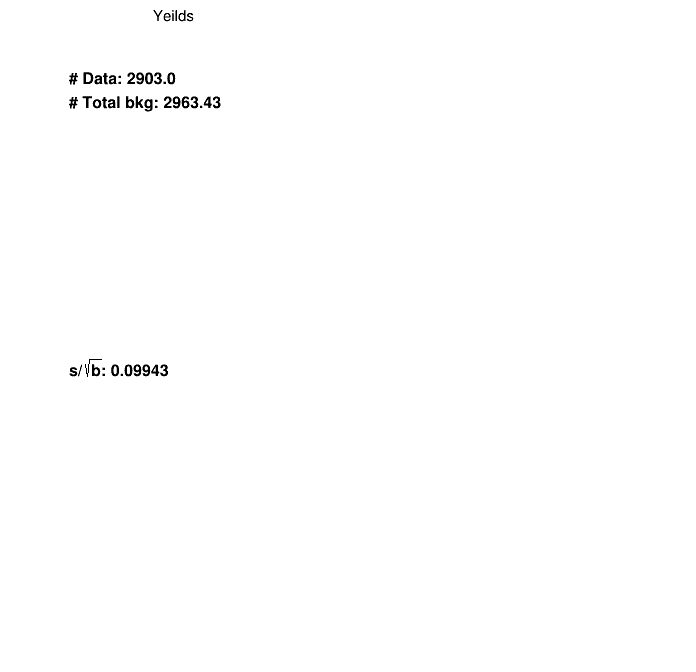

In [22]:
if DRAW_SR:
    region = "SR"

    with Pool() as p:
        p.starmap(wrapper_mp, list_variables) 
#     wrapper_mp('mass_pre', [45, 100, 1000, 'M_{ll} [GeV]'])

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)

array('f', [4.390909671783447, 4.866497039794922, 10.618252754211426, 117.42652893066406, 263.6268310546875, 2580.663330078125, 100.35726928710938, 5.417418956756592])
test


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/wotop/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/wotop/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_PuppiMET_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/wotop/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_lead_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/SR/wotop/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_lead_pre.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanv

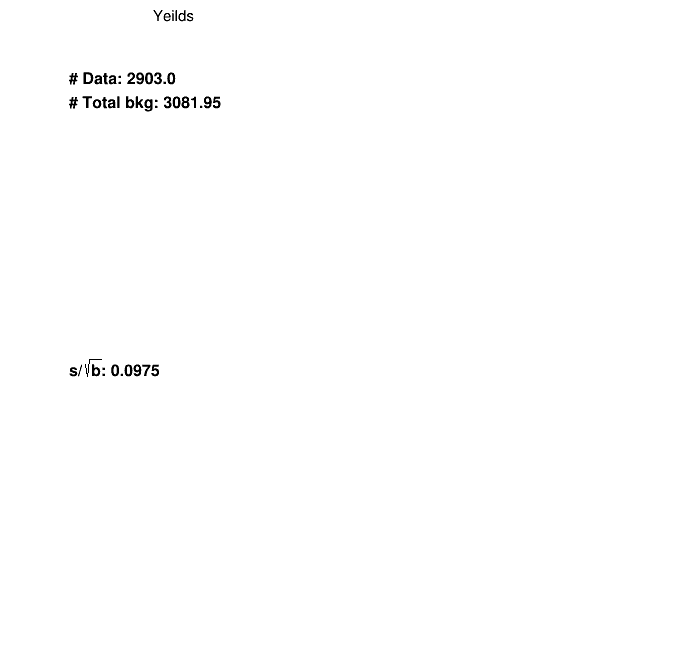

In [23]:
###### wotop ######
dic_variable={
    "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
    "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
    "pt_trail_pre": [15, 40, 520, "p_{T}(l_{trail}) [GeV]"], 
}
os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region+"/wotop")

for variable, r in dic_variable.items():
    if not "Puppi" in variable:
        threshold = 0.3
    else:
        threshold = 0.5
    hist=HistStack(dic_df_raw, variable, "wotop", r[0], r[1], r[2], r[3])  
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/norm_"+query_str, blind_from=threshold) 
hist.get_yeilds()
hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/wotop/pie_"+query_str)  

In [24]:
dic_df_raw["TT"]["trigSF_pre"]

15       1.001046
16       0.997926
18       1.000533
27       0.992304
28       0.953071
           ...   
67752    1.001760
67765    0.999545
67782    0.996168
67784    0.998616
67792    0.995215
Name: trigSF_pre, Length: 75398, dtype: float32

# MET side band

####################################################
####   (unweighted) #events after preselection  ####
####################################################
DY1000To1500 : 6
DY1500To2000 : 315
DY2000To3000 : 33
DY500To700 : 270
DY700To800 : 162
DY800To1000 : 285
Zp-1700_CH-345 : 593
Zp-1700_CH-595 : 416
Zp-1700_CH-845 : 334
Zp-2100_CH-345 : 495
Zp-2100_CH-595 : 380
Zp-2100_CH-845 : 307
Zp-2500_CH-345 : 517
Zp-2500_CH-845 : 287
Zp-2900_CH-1095 : 212
Zp-2900_CH-1345 : 176
Zp-2900_CH-345 : 423
Zp-2900_CH-595 : 372
Zp-2900_CH-845 : 283
Zp-3300_CH-1095 : 205
Zp-3300_CH-1345 : 154
Zp-3300_CH-1595 : 166
Zp-3300_CH-345 : 405
Zp-3300_CH-595 : 308
Zp-3700_CH-1095 : 237
Zp-3700_CH-1345 : 162
Zp-3700_CH-1595 : 130
Zp-3700_CH-1845 : 124
Zp-3700_CH-345 : 368
Zp-3700_CH-595 : 303
Zp-3700_CH-845 : 266
Zp-4100_CH-1095 : 197
Zp-4100_CH-1345 : 140
Zp-4100_CH-1595 : 142
Zp-4100_CH-1845 : 117
Zp-4100_CH-345 : 344
Zp-4100_CH-595 : 294
Zp-4100_CH-845 : 254
TT : 38258
TTSemi : 35
TTZ : 1893
DY : 213
top : 2

       5.50635332e-04, 1.08320812e-02, 3.55452436e-02])}
here {'puweightUp': array([2.15043759e+00, 1.87199788e+00, 2.23405244e+01, 5.21254709e+00,
       6.02136697e+00, 2.49548063e-02, 5.13068594e-01, 4.68769602e-01,
       4.25633852e-02, 1.29698451e+00, 6.71870749e-01, 1.10685977e-02,
       7.18242558e-02, 6.81785345e-01, 5.16632384e-04, 5.93170092e-03,
       8.53391627e-05, 3.78910123e-02, 2.94772484e-03, 6.41242898e-05,
       4.42606894e-05, 3.05099715e-06, 2.25441117e-04, 7.51236854e-04,
       3.10542810e-04, 7.11295795e-04, 2.18419591e-03, 1.45620550e-05,
       2.91694737e-07, 1.15821218e-04, 1.08662232e-03]), 'puweightDown': array([5.50687186e-01, 5.11610926e+00, 2.42820392e+01, 6.69562528e+00,
       2.71574876e+00, 1.05599143e-01, 8.88066448e-01, 4.70334638e-01,
       8.75394134e-02, 1.37893924e+00, 6.25807979e-01, 1.31336192e-02,
       6.51779032e-02, 5.80049238e-01, 1.05762776e-03, 7.37111301e-03,
       3.77379468e-04, 3.81365755e-02, 2.84192113e-03, 2.95527486e-04

        0.        , 18.91585626, 16.49571902, 31.71495647, 13.49370764])}
here {'puweightUp': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 23.52219262,  8.19055939,  0.87321902, 18.49507479]), 'puweightDown': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 24.82156451,  7.95902306,  0.75981735, 21.0279153 ]), 'l1prefiringUp': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 5.74253395, 3.89721739, 2.14791037, 2.163758  ]), 'l1prefiringDown': arra

       4.06873001e-04, 2.65274882e-02])}
here {'puweightUp': array([3.91311620e+00, 2.00405682e+01, 7.34384945e-01, 8.75009975e+00,
       9.56575107e-01, 1.30172893e-01, 1.03110396e-01, 1.70501105e+00,
       3.46560529e-02, 0.00000000e+00, 1.30163614e-02, 1.54825014e-01,
       2.44592700e-03, 0.00000000e+00, 1.43646350e-03, 2.70934853e-03,
       4.04733137e-04, 3.95521074e-04, 8.10869238e-04, 0.00000000e+00,
       3.07177159e-04, 3.55041910e-03, 4.42468004e-05, 1.51991324e-03,
       3.06541822e-04, 1.62288454e-06, 1.18085276e-06, 3.65030975e-05,
       1.59485417e-07, 6.65983797e-04]), 'puweightDown': array([2.68195887e-01, 2.22337809e+01, 2.38561987e+00, 1.16534908e+01,
       1.11538358e+00, 2.01247704e-01, 1.30746255e-01, 1.82803827e+00,
       7.42586409e-02, 5.67881424e-04, 1.48887652e-02, 1.60316113e-01,
       3.93124803e-03, 5.71395799e-05, 5.93032030e-04, 2.17096193e-03,
       3.15554267e-04, 5.54276002e-04, 5.37936792e-04, 3.51240767e-06,
       2.95656619e-04, 4.70550

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/METSB/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80_pt_lead_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/METSB/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80_pt_trail_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/METSB/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80_PuppiMET_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/METSB/sys/norm_mass_pre>100 and pt_lead_pre>80 and pt_trail_pr

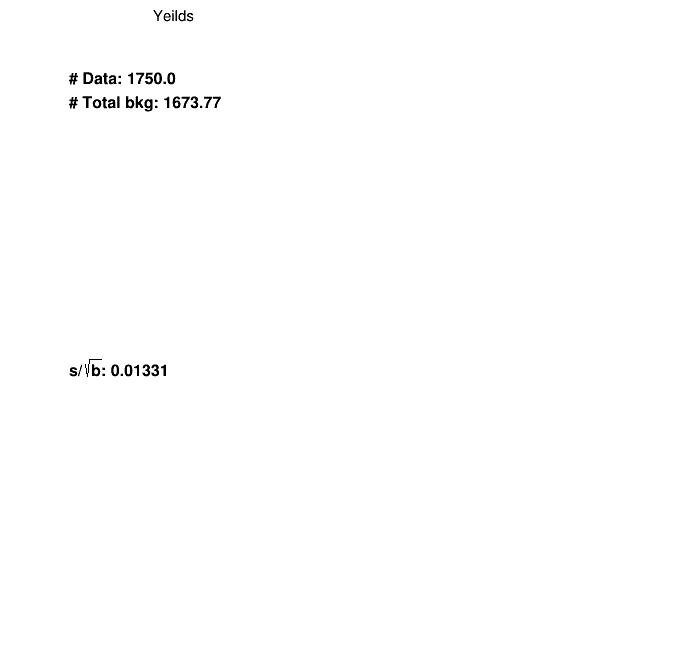

In [25]:
if RUN_SIDEBAND_MET:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp    
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    dic_variable={
        "PuppiMET_pre": [20, 0, 100, "Puppi p_{T}^{miss} [GeV]"],    
#         "MET_pre": [40, 0, 400, "p_{T}^{miss} [GeV]"],    
#         "mass_pre": [30, 100, 700, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [50, 0, 500, "p_{T}(ll) [GeV]"],
#         "MT_pre": [55, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [35, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [29, 0, 660, "U [GeV]"],
#         "JZB_pre": [29, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
    #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
    #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
    #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],      
    }
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "METSB"
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)        

In [26]:
if DUMP_SIDEBAND_MET_PKL:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_METSB.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# Mass side band

In [27]:
if RUN_SIDEBAND_MASS and not "em" in ERA:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    
    dic_variable={
        "PuppiMET_pre": [28, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
        "mass_pre": [1,80, 100, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],     
    }

    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "MASSSB"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "mass_pre", "weight", 1, 80,  100, "M_{ll} [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.get_yeilds()
    hist.create_root_file(file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB") 
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)
    
    sys_list = ["puweight", "l1prefiring", "effSF", "topSF", "trigSF"] 
#     sys_list = ["puweight", "l1prefiring", "effSF", "topSF"] 
    for s in sys_list:
        hist=HistStack(dic_df_raw, "mass_pre", 'weight'+s+'Up', 1, 80,  100, "M_{ll} [GeV]")
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
        hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
        hist=HistStack(dic_df_raw, "mass_pre", 'weight'+s+'Down', 1, 80,  100, "M_{ll} [GeV]")
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
        hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")
    hist=HistStack(dic_df_met_u_tmp, "mass_pre", 'weightmetUp', 1, 80,  100, "M_{ll} [GeV]")
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB") 
    hist=HistStack(dic_df_met_d_tmp, "mass_pre", 'weightmetDown', 1, 80,  100, "M_{ll} [GeV]")
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/massSB_"+query_str) 
    hist.export_hist("Zp-2500_CH-345", file_name=DATE+"/Presel/"+ERA+"/"+region+"/shape_v1_massSB")      

####################################################
####   (unweighted) #events after preselection  ####
####################################################
DY1000To1500 : 0
DY1500To2000 : 0
DY2000To3000 : 0
DY500To700 : 0
DY700To800 : 0
DY800To1000 : 0
Zp-1700_CH-345 : 10
Zp-1700_CH-595 : 168
Zp-1700_CH-845 : 450
Zp-2100_CH-345 : 2
Zp-2100_CH-595 : 72
Zp-2100_CH-845 : 249
Zp-2500_CH-345 : 0
Zp-2500_CH-845 : 127
Zp-2900_CH-1095 : 142
Zp-2900_CH-1345 : 224
Zp-2900_CH-345 : 3
Zp-2900_CH-595 : 16
Zp-2900_CH-845 : 75
Zp-3300_CH-1095 : 117
Zp-3300_CH-1345 : 130
Zp-3300_CH-1595 : 157
Zp-3300_CH-345 : 2
Zp-3300_CH-595 : 6
Zp-3700_CH-1095 : 59
Zp-3700_CH-1345 : 85
Zp-3700_CH-1595 : 115
Zp-3700_CH-1845 : 164
Zp-3700_CH-345 : 2
Zp-3700_CH-595 : 5
Zp-3700_CH-845 : 31
Zp-4100_CH-1095 : 47
Zp-4100_CH-1345 : 69
Zp-4100_CH-1595 : 77
Zp-4100_CH-1845 : 112
Zp-4100_CH-345 : 0
Zp-4100_CH-595 : 2
Zp-4100_CH-845 : 18
TT : 18571
TTSemi : 41
TTZ : 15198
DY : 499
top : 27
antitop : 26
ZZ : 50768
WZ : 13717


       0.00000000e+00, 0.00000000e+00])}
here {'puweightUp': array([2.24334704e+02, 1.70313782e+02, 2.41563279e+01, 1.26721971e+01,
       1.39176486e+00, 1.22379651e-04, 6.85499448e-01, 3.10568031e-01,
       2.77895910e-02, 4.65295467e-01, 3.75923460e-02, 1.77155465e-02,
       6.11685054e-03, 3.23332679e-02, 0.00000000e+00, 4.22557024e-04,
       6.14737967e-05, 8.94294884e-05, 7.30851815e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.09266161e-09, 0.00000000e+00,
       6.60198872e-07, 7.79301889e-09, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'puweightDown': array([1.53847254e+02, 7.70664819e+01, 2.79784487e+00, 1.56482776e+01,
       7.43443366e-01, 2.03001461e-02, 7.28329500e-01, 2.68311178e-01,
       3.13139778e-02, 4.60750087e-01, 3.42160693e-02, 1.65857050e-02,
       2.26632702e-02, 5.10608681e-02, 1.03970320e-03, 4.03410314e-04,
       4.80053694e-05, 7.96339556e-05, 1.45781318e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000

here {'puweightUp': array([916.52114377]), 'puweightDown': array([405.608687]), 'l1prefiringUp': array([15.44754518]), 'l1prefiringDown': array([16.1799848]), 'effSFUp': array([795.14181242]), 'effSFDown': array([751.35036002]), 'topSFUp': array([5.62312179]), 'topSFDown': array([0.]), 'metUp': array([1175.74575765]), 'metDown': array([684.26396346]), 'trigSFUp': array([7.5857834]), 'trigSFDown': array([9.17189433]), 'sum_up': array([54.00060337]), 'sum_down': array([43.20387586])}
{'puweightUp': array([1.66244891e+02, 3.24770314e+02, 1.97288997e-03, 1.47372130e-02,
       2.15755929e-01, 8.00990607e-03, 1.52406245e-02, 6.29034718e-02,
       3.99455320e-02, 2.18897511e-02, 2.87127733e-03, 7.16750949e-02,
       1.32097944e-02, 1.22985473e-03, 9.87265205e-03, 1.60222745e-03,
       6.75341772e-06, 8.55238904e-06, 5.05218457e-05, 7.75389460e-05,
       0.00000000e+00, 5.86539877e-04, 2.00094305e-05, 7.29430915e-03,
       7.59166962e-04, 2.08189370e-04, 7.13097412e-05, 1.89305037e-06]),

       1.23653051e-01, 1.75590216e-02, 8.91885019e-03, 4.54682600e-02])}
{'puweightUp': array([5.64208517e+00, 2.90298104e+02, 4.02785770e+00, 5.41813490e+00,
       2.13678684e+00, 5.10317339e-02, 7.02757786e-01, 2.28332114e+01,
       8.63227551e-02, 2.29227807e+00, 1.61122599e-01, 1.54041999e-01,
       8.57543813e-03, 1.85687972e+00, 4.06741393e-01, 8.85517105e-02,
       5.50739104e-01, 7.45246034e-03, 5.36968055e-02, 1.44601193e-02,
       6.08733470e-03, 2.25153813e-01, 5.11506235e-02, 2.17793694e-02,
       1.60119802e-04, 3.95050269e-04, 3.67313386e-03, 7.27486175e-03,
       2.25970082e-04, 2.59499614e-04, 2.19876572e-03]), 'puweightDown': array([1.12203841e+01, 1.15642984e+02, 5.86450840e+00, 3.26966894e+00,
       2.42477725e+00, 1.98158532e-01, 2.55218838e-01, 1.35061231e-01,
       7.79264033e-02, 2.16435904e+00, 3.45202305e-01, 1.90016357e-01,
       2.83374428e-02, 2.56459781e+00, 2.76623023e-01, 1.35581929e-02,
       4.56869518e-01, 1.48020770e-02, 6.80669688e-02, 1.7

       1.65122299e-02, 1.80414826e-02, 5.67375468e-02])}
array('f', [10.540047645568848, 32.18274688720703, 38.841705322265625, 9.827940940856934, 13.515048027038574, 379.7348327636719, 321.3490905761719, 0.0])
test


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/MASSSB/sys/norm_mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_trail_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/MASSSB/sys/norm_mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_mass_prebreakdown.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/MASSSB/sys/norm_mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100_pt_trail_pre.pdf has been created
Info in <TCanvas::Print>: pdf file 20230427wp80_16pre/Presel/ee16pre/MASSSB/sys/norm_mass_pre<100 and pt_lead_pre>80 and pt_trail_

In [28]:
if DUMP_SIDEBAND_MASS_PKL and not "em" in ERA:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_MASS.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# PT side band

####################################################
####   (unweighted) #events after preselection  ####
####################################################
DY1000To1500 : 0
DY1500To2000 : 42
DY2000To3000 : 4
DY500To700 : 38
DY700To800 : 36
DY800To1000 : 38
Zp-1700_CH-345 : 529
Zp-1700_CH-595 : 441
Zp-1700_CH-845 : 337
Zp-2100_CH-345 : 495
Zp-2100_CH-595 : 460
Zp-2100_CH-845 : 337
Zp-2500_CH-345 : 488
Zp-2500_CH-845 : 351
Zp-2900_CH-1095 : 258
Zp-2900_CH-1345 : 224
Zp-2900_CH-345 : 429
Zp-2900_CH-595 : 404
Zp-2900_CH-845 : 373
Zp-3300_CH-1095 : 268
Zp-3300_CH-1345 : 178
Zp-3300_CH-1595 : 180
Zp-3300_CH-345 : 371
Zp-3300_CH-595 : 402
Zp-3700_CH-1095 : 242
Zp-3700_CH-1345 : 190
Zp-3700_CH-1595 : 208
Zp-3700_CH-1845 : 174
Zp-3700_CH-345 : 363
Zp-3700_CH-595 : 348
Zp-3700_CH-845 : 307
Zp-4100_CH-1095 : 235
Zp-4100_CH-1345 : 198
Zp-4100_CH-1595 : 178
Zp-4100_CH-1845 : 156
Zp-4100_CH-345 : 384
Zp-4100_CH-595 : 319
Zp-4100_CH-845 : 266
TT : 25596
TTSemi : 46
TTZ : 1932
DY : 21
top : 178
ant

       4.02242735, 0.        ])}
here{'puweightUp': array([0.00000000e+00, 5.45221152e-03, 1.25186051e-02, 7.95604525e-04,
       5.00410401e-01, 3.17738229e-01, 8.10759584e-01, 9.35290107e-01,
       4.96372936e-01, 9.63224455e-01, 2.99530610e+00, 2.74711011e+00,
       7.06630343e-01, 4.11492638e+00, 6.90198803e-01, 3.32727464e-01,
       4.89824928e-01, 1.71682504e-01, 2.12536380e-01, 2.00611940e-01,
       1.90494192e-01, 6.63318754e-02, 1.46122834e-03, 1.48847369e-03,
       2.43745971e-02, 5.88523795e-03, 3.16869212e-02]), 'puweightDown': array([0.00000000e+00, 5.08130206e-03, 4.06873666e-03, 1.78924730e-02,
       5.16095103e-01, 2.48919913e-01, 9.30202495e-01, 1.01584405e+00,
       6.04470369e-01, 1.42163825e+00, 3.72347020e+00, 3.62026119e+00,
       1.69936683e+00, 3.80743597e+00, 8.90757628e-01, 6.29432020e-01,
       6.73044096e-01, 1.59720950e-01, 2.41511343e-01, 1.82365444e-01,
       1.52202990e-01, 6.36720643e-02, 4.89805167e-03, 3.13326114e-03,
       2.64343991e-02, 

       4.02242735, 0.        ])} 
{'puweightUp': array([0.00000000e+00, 5.45221152e-03, 1.25186051e-02, 7.95604525e-04,
       5.00410401e-01, 3.17738229e-01, 8.10759584e-01, 9.35290107e-01,
       4.96372936e-01, 9.63224455e-01, 2.99530610e+00, 2.74711011e+00,
       7.06630343e-01, 4.11492638e+00, 6.90198803e-01, 3.32727464e-01,
       4.89824928e-01, 1.71682504e-01, 2.12536380e-01, 2.00611940e-01,
       1.90494192e-01, 6.63318754e-02, 1.46122834e-03, 1.48847369e-03,
       2.43745971e-02, 5.88523795e-03, 3.16869212e-02]), 'puweightDown': array([0.00000000e+00, 5.08130206e-03, 4.06873666e-03, 1.78924730e-02,
       5.16095103e-01, 2.48919913e-01, 9.30202495e-01, 1.01584405e+00,
       6.04470369e-01, 1.42163825e+00, 3.72347020e+00, 3.62026119e+00,
       1.69936683e+00, 3.80743597e+00, 8.90757628e-01, 6.29432020e-01,
       6.73044096e-01, 1.59720950e-01, 2.41511343e-01, 1.82365444e-01,
       1.52202990e-01, 6.36720643e-02, 4.89805167e-03, 3.13326114e-03,
       2.64343991e-02, 3.7

       3.23593216, 1.91661878, 2.11439999, 0.92505566, 0.        ])}
here {'puweightUp': array([0.        , 0.70552046, 0.51810885, 1.40536846, 1.52176139,
       4.59499934, 4.26891268, 7.94617649, 1.89058647, 0.7522177 ,
       1.20773558, 0.38915106, 1.05483633, 0.04582954, 0.        ]), 'puweightDown': array([0.        , 0.58947903, 0.58705925, 1.54973083, 2.14371517,
       5.86447923, 5.70993082, 9.74281162, 1.71179082, 1.54187049,
       1.52322666, 0.45987505, 0.96899465, 0.07132505, 0.        ]), 'l1prefiringUp': array([0.        , 0.16093178, 0.08911327, 0.0288336 , 0.15298062,
       0.15053753, 0.33333895, 0.25645357, 0.3357673 , 0.18441449,
       0.13567482, 0.03884111, 0.18422149, 0.45100766, 0.        ]), 'l1prefiringDown': array([0.        , 0.16018611, 0.09383304, 0.0315218 , 0.16790085,
       0.16765445, 0.37014981, 0.28588601, 0.36394121, 0.20231583,
       0.14939992, 0.04148615, 0.18779636, 0.4450083 , 0.        ]), 'effSFUp': array([ 0.        ,  0.5675973 ,  3.

       0.00000000e+00, 0.00000000e+00])}
here {'puweightUp': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.58738638e-05,
       4.25169123e-05, 4.34633067e-03, 9.88187029e-03, 1.54672630e-01,
       4.48874203e-02, 0.00000000e+00, 8.74760296e-01, 4.07707732e+00,
       7.20324848e+00, 6.48944546e+00, 2.93844734e+00, 5.24264405e+00,
       3.30631830e+00, 3.54114053e-01, 2.84630747e-01, 9.97191079e-02,
       2.73434428e-02, 2.37585379e-02, 2.96539888e-03, 2.73233460e-03,
       1.06271293e-04, 8.82647946e-05, 3.12014069e-06, 2.29158494e-05,
       0.00000000e+00, 0.00000000e+00]), 'puweightDown': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.34996665e-05,
       6.56576238e-05, 1.81492126e-02, 5.56508861e-03, 2.83837565e-01,
       3.60661999e-02, 1.22529076e-02, 1.60762897e+00, 5.21925407e+00,
       8.93626210e+00, 7.38443268e+00, 3.15727998e+00, 5.60941115e+00,
       3.75426034e+00, 3.75887963e-01, 3.48855185e-01, 9.34662164e-02,
       1.74683781e-02, 2.56361

here {'puweightUp': array([  0.        ,   0.        ,  31.94459562, 101.61781677]), 'puweightDown': array([  0.        ,   0.        ,  37.63389296, 127.09445027]), 'l1prefiringUp': array([ 0.        ,  0.        ,  2.76111401, 14.031059  ]), 'l1prefiringDown': array([ 0.        ,  0.        ,  2.92593602, 15.05111363]), 'effSFUp': array([  0.        ,   0.        , 155.46714174, 564.34879088]), 'effSFDown': array([  0.        ,   0.        , 147.32619047, 538.13509025]), 'topSFUp': array([  0.        ,   0.        ,  99.91583955, 520.66609186]), 'topSFDown': array([0.00000000e+00, 0.00000000e+00, 1.38777878e-17, 0.00000000e+00]), 'trigSFUp': array([ 0.        ,  0.        , 15.09503058,  7.4837014 ]), 'trigSFDown': array([ 0.        ,  0.        , 15.94501286,  8.00517781]), 'sum_up': array([ 0.        ,  0.        , 17.46950834, 34.75841567]), 'sum_down': array([ 0.        ,  0.        , 14.27694058, 26.23520215])}
{'puweightUp': array([2.83362168e+00, 1.45992345e+00, 5.40560104e-01

       2.26715813e-03, 2.06948026e-02])}
{'puweightUp': array([5.04061787e-02, 1.56351794e+00, 4.88162501e-01, 3.56945772e-03,
       5.28069869e-01, 7.02818408e-01, 4.33917260e-01, 2.72042794e-01,
       4.28973344e-01, 3.73232401e-01, 3.50478237e-01, 7.94742270e-01,
       4.94613635e+00, 3.91187889e+00, 4.58576443e+00, 2.76126777e+00,
       0.00000000e+00]), 'puweightDown': array([0.        , 1.61746461, 0.54938948, 0.04497831, 0.75307744,
       0.94256567, 0.56472541, 0.30680311, 0.60100835, 0.48931338,
       0.54051175, 0.92369602, 5.86136445, 5.59336726, 4.82713941,
       3.61122326, 0.        ]), 'l1prefiringUp': array([0.13045708, 0.10905577, 0.13146911, 0.0767698 , 0.04208189,
       0.05997191, 0.05131495, 0.02930108, 0.05814206, 0.05107427,
       0.09369975, 0.08660891, 0.15162454, 0.45454042, 0.30006294,
       0.30223596, 0.        ]), 'l1prefiringDown': array([0.1359266 , 0.11594616, 0.13594988, 0.08152726, 0.04417008,
       0.06240059, 0.05450812, 0.03157295, 0.062

       3.89783288, 2.0281837 , 2.62856941, 0.70893085, 0.        ])}
{'puweightUp': array([6.48250130e+00, 1.62471293e+01, 9.23828170e+00, 1.50233055e+00,
       9.04961752e+00, 3.77756385e-01, 1.07742509e-01, 1.44986044e-04,
       1.28569217e-01, 6.61901139e-02, 8.11211447e-04, 3.01642667e-03,
       7.14282721e-03, 2.44882494e-02]), 'puweightDown': array([8.59388920e+00, 1.97465943e+01, 1.19455217e+01, 2.74184203e+00,
       8.80943675e+00, 2.60912383e-01, 1.80544763e-01, 7.09050578e-07,
       1.32807634e-01, 7.16066997e-02, 1.97840722e-03, 6.10900396e-03,
       9.51663684e-03, 3.13260997e-02]), 'l1prefiringUp': array([4.41726381e-01, 1.34073201e+00, 8.49900040e-01, 5.86303934e-01,
       5.38784836e-01, 2.25104731e-01, 8.70333590e-02, 1.79722373e-02,
       7.84943760e-03, 3.72861752e-03, 6.09782249e-04, 1.87605245e-04,
       7.05513968e-05, 4.01190275e-03]), 'l1prefiringDown': array([4.78159393e-01, 1.44687408e+00, 9.20272424e-01, 6.33187700e-01,
       5.66065172e-01, 2.364148

       0.04920359, 0.07188149, 0.03898158, 0.03257406, 0.04230529])}{'puweightUp': array([8.62931819e+01, 1.07364991e+01, 1.58128865e+00, 3.93729890e-01,
       3.77620664e-01, 1.55978655e-02, 1.45040039e-01, 4.93456854e-04,
       9.81822415e-05, 3.13983374e-03, 0.00000000e+00, 4.70696118e-03,
       1.15908707e-04, 5.12656386e-06]), 'puweightDown': array([1.09162507e+02, 1.31323746e+01, 2.12155043e+00, 4.30944997e-01,
       2.64251094e-01, 2.08604752e-02, 1.39784348e-01, 1.35268250e-03,
       4.84987237e-04, 3.18153198e-03, 3.96977416e-05, 4.10475430e-03,
       1.63414690e-04, 9.55280288e-09]), 'l1prefiringUp': array([9.73400758e+00, 1.43208990e+00, 2.89200927e-01, 7.51000329e-02,
       1.36282378e-02, 2.18949053e-03, 5.62260929e-03, 7.81284404e-04,
       8.77433102e-06, 2.76013222e-05, 5.94608470e-06, 4.23025187e-07,
       2.57375610e-07, 5.34865792e-07]), 'l1prefiringDown': array([1.04552607e+01, 1.52722538e+00, 3.09087668e-01, 7.74683969e-02,
       1.42379610e-02, 2.3527658

       0.00000000e+00])}
  here{'puweightUp': array([8.62931819e+01, 1.07364991e+01, 1.58128865e+00, 3.93729890e-01,
       3.77620664e-01, 1.55978655e-02, 1.45040039e-01, 4.93456854e-04,
       9.81822415e-05, 3.13983374e-03, 0.00000000e+00, 4.70696118e-03,
       1.15908707e-04, 5.12656386e-06]), 'puweightDown': array([1.09162507e+02, 1.31323746e+01, 2.12155043e+00, 4.30944997e-01,
       2.64251094e-01, 2.08604752e-02, 1.39784348e-01, 1.35268250e-03,
       4.84987237e-04, 3.18153198e-03, 3.96977416e-05, 4.10475430e-03,
       1.63414690e-04, 9.55280288e-09]), 'l1prefiringUp': array([9.73400758e+00, 1.43208990e+00, 2.89200927e-01, 7.51000329e-02,
       1.36282378e-02, 2.18949053e-03, 5.62260929e-03, 7.81284404e-04,
       8.77433102e-06, 2.76013222e-05, 5.94608470e-06, 4.23025187e-07,
       2.57375610e-07, 5.34865792e-07]), 'l1prefiringDown': array([1.04552607e+01, 1.52722538e+00, 3.09087668e-01, 7.74683969e-02,
       1.42379610e-02, 2.35276584e-03, 5.84955261e-03, 8.21814429e-04

       0.04920359, 0.07188149, 0.03898158, 0.03257406, 0.04230529])}
{'puweightUp': array([5.69118467e+01, 9.26251771e+00, 9.72403693e+00, 1.02464202e+01,
       1.84639593e-01, 1.43927468e-01, 3.65772768e-02, 3.57672815e-04,
       3.37676457e-05, 3.04873126e-06, 3.40996137e-09, 2.54823564e-05,
       1.25088727e-08, 5.52797013e-05, 0.00000000e+00, 6.68998278e-04,
       0.00000000e+00]), 'puweightDown': array([5.87540069e+01, 1.09388474e+01, 1.23997678e+01, 1.23772701e+01,
       6.67073977e-01, 2.94770417e-01, 4.28278919e-02, 4.69033730e-04,
       4.38668697e-05, 1.78945857e-05, 7.85720987e-09, 2.70936647e-05,
       1.57462413e-08, 9.73067889e-05, 0.00000000e+00, 4.59709586e-04,
       0.00000000e+00]), 'l1prefiringUp': array([4.05256516e+00, 6.60183004e-01, 9.88024890e-01, 9.29477925e-01,
       1.82869290e-01, 9.86564277e-03, 7.39045955e-03, 5.94653765e-05,
       2.09345834e-06, 1.51684628e-06, 9.70772936e-12, 1.03392855e-08,
       0.00000000e+00, 8.11699494e-08, 0.00000000e+0

       0.00000000e+00, 0.00000000e+00])}
{'puweightUp': array([5.00148089e+01, 2.99638529e+01, 4.37626372e+00, 4.18537649e-02,
       4.00605345e-02, 1.26503530e-01, 9.12980238e-02, 1.32639811e-03,
       0.00000000e+00, 6.68717538e-04, 8.90462577e-06, 0.00000000e+00,
       0.00000000e+00, 6.49732562e-06, 4.90767204e-05]), 'puweightDown': array([7.00790211e+01, 3.34956785e+01, 3.54725425e+00, 1.29031157e-01,
       7.27434120e-02, 1.28157772e-01, 8.58253222e-02, 2.07503846e-03,
       1.05351850e-04, 1.57401489e-03, 9.21244971e-05, 7.45269186e-06,
       1.67079657e-06, 2.16400199e-05, 1.34063823e-04]), 'l1prefiringUp': array([9.52945659e+00, 1.80146756e+00, 2.60484500e-01, 5.14425123e-02,
       1.07551123e-02, 1.23867084e-03, 9.13457327e-04, 4.44377032e-05,
       4.89857628e-04, 1.40910166e-03, 3.77933310e-06, 2.23222418e-06,
       2.08453251e-08, 2.78102612e-06, 1.58250340e-07]), 'l1prefiringDown': array([1.01665026e+01, 1.93078509e+00, 2.79957685e-01, 5.54267430e-02,
       1.14

       0.00000000e+00, 0.00000000e+00])}
{'puweightUp': array([0.11169411, 0.79261892, 0.34884711, 0.76520563, 0.67905774,
       0.21024635, 0.15508769, 0.61048264, 0.11948377, 0.07362367,
       0.62220691, 0.69170682, 1.64669559, 8.08818432, 2.66217962,
       6.70079278, 0.        ]), 'puweightDown': array([0.06552931, 0.61285785, 0.46449669, 0.91440079, 0.8616939 ,
       0.41356018, 0.20202682, 0.6456328 , 0.20442419, 0.19526403,
       0.73209989, 1.03906885, 2.10145755, 9.84889914, 3.61911234,
       7.01172504, 0.        ]), 'l1prefiringUp': array([0.11951104, 0.14624452, 0.11579869, 0.09764524, 0.05583419,
       0.05705293, 0.02671766, 0.03719592, 0.04064778, 0.06446934,
       0.0561159 , 0.08571299, 0.23980823, 0.34900311, 0.39789626,
       0.24866786, 0.        ]), 'l1prefiringDown': array([0.12723315, 0.15332189, 0.12000866, 0.10175006, 0.05893633,
       0.05945769, 0.02872534, 0.04004749, 0.04297065, 0.07030521,
       0.06073287, 0.09274595, 0.25627933, 0.37550589, 0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas:

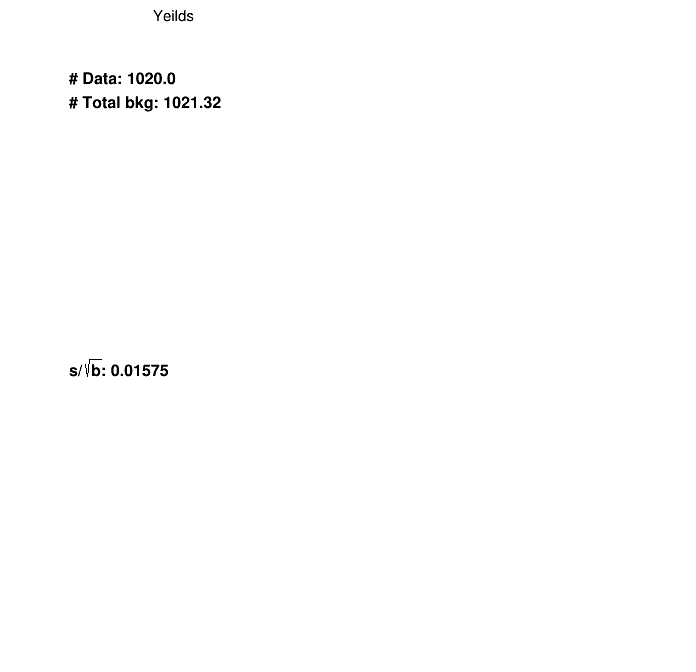

In [29]:
if RUN_SIDEBAND_PT:
    dic_df_raw={}
    dic_df_met_u_tmp = {}
    dic_df_met_d_tmp = {}
    dic_df_scale_u_tmp = {}
    dic_df_scale_d_tmp = {}
    # query_str="mass_pre<100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre<40 and PuppiMET_pre>100"
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre<100 and PuppiMET_pre>80"
    # query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and MET_pre>80"
    # query_str="mass_pre>60"

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)
        dic_df_met_u_tmp[key]=dic_df_met_u[key].query(query_str)
        dic_df_met_d_tmp[key]=dic_df_met_d[key].query(query_str)     
#         dic_df_scale_u_tmp[key]=dic_df_scale_u[key].query(query_str)
#         dic_df_scale_d_tmp[key]=dic_df_scale_d[key].query(query_str) 
        print(key, ":", dic_df_raw[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_u[key].shape[0])
    #     print("num of", key, ":", dic_df_jes_d[key].shape[0])
    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u_tmp
    nested_dic_df["met_d"]=dic_df_met_d_tmp    
#     nested_dic_df["scale_u"]=dic_df_scale_u_tmp
#     nested_dic_df["scale_d"]=dic_df_scale_d_tmp
    dic_variable={
        "PuppiMET_pre": [14, 100, 660, "Puppi p_{T}^{miss} [GeV]"],    
#         "MET_pre": [40, 0, 400, "p_{T}^{miss} [GeV]"],    
        "mass_pre": [22, 100, 1000, "M_{ll} [GeV]"],
        "pt_lead_pre": [15, 80,  660, "p_{T}(l_{lead}) [GeV]"],
        "pt_trail_pre": [4, 0, 40, "p_{T}(l_{trail}) [GeV]"],
        "Zpt_pre": [25, 0, 500, "p_{T}(ll) [GeV]"],
        "MT_pre": [27, 0, 550, "M_{T} [GeV]"],
        "MT2_pre": [17, 0, 350, "M_{T2} [GeV]"],
        "U_pre": [14, 0, 660, "U [GeV]"],
        "JZB_pre": [14, 80, 660, "JZB"],
        "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
        "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
        "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
        "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
    #     "MC1C1_pre": [36, 180, 900, "MC1C1 [GeV]"], 
    #     "H3PP_pre": [41, 80, 900, "H3PP [GeV]"], 
    #     "H3TPP_pre": [40, 0, 800, "H3TPP [GeV]"], 
        "eta_lead_pre": [15, -3, 3, "#eta(l_{lead})"],
        "eta_trail_pre": [15, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
        "PuppiMET_phi_pre": [20, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"],      
    }
    list_variables = [(key, dic_variable[key]) for key in dic_variable]
    
    region = "PTSB"
    os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/"+region)
    
    with Pool() as p:
        p.starmap(wrapper_mp, list_variables)    

    # for pie chart
    hist=HistStack(dic_df_raw, "pt_lead_pre", "weight", 31, 80,  660, "p_{T}(l_{lead}) [GeV]") 
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/"+region+"/preselv1_"+query_str) 
    hist.get_yeilds()
    hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/"+region+"/pie_"+query_str)        

In [30]:
if DUMP_SIDEBAND_PT_PKL:
    with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_PT.pkl", "wb") as f:
        pickle.dump(nested_dic_df, f)

# b tag selection

In [31]:
if RUN_BTAG:
    dic_variable={
        "MET_pre": [25, 0, 500, "p_{T}^{miss} [GeV]"],    
#         "PuppiMET_pre": [50, 0, 500, "Puppi p_{T}^{miss} [GeV]"],    
#         "mass_pre": [30, 100, 700, "M_{ll} [GeV]"],
        "pt_lead_pre": [31, 80,  660, "p_{T}(l_{lead}) [GeV]"],
#         "pt_trail_pre": [30, 40, 520, "p_{T}(l_{trail}) [GeV]"],
#         "Zpt_pre": [50, 0, 500, "p_{T}(ll) [GeV]"],
        "MT_pre": [55, 0, 550, "M_{T} [GeV]"],
#         "MT2_pre": [35, 0, 350, "M_{T2} [GeV]"],
#         "U_pre": [29, 0, 660, "U [GeV]"],
#         "JZB_pre": [29, 80, 660, "JZB"],
#         "dPhill_pre": [17, 0, 3.4, "#Delta#phi(l,l)"],
#         "dPhilMET_pre": [17, 0, 3.4, "#Delta#phi(l,p_{T}^{miss})"],
#         "dRll_pre": [30, 0, 6, "#DeltaR(l,l)"],
#         "dPhillMET_pre": [17, 0, 3.4, "#Delta#phi(ll,p_{T}^{miss})"],
#         "eta_lead_pre": [30, -3, 3, "#eta(l_{lead})"],
#         "eta_trail_pre": [30, -3, 3, "#eta(l_{trail})"],
#         "phi_lead_pre": [40, -4, 4, "#phi(l_{lead})"],
#         "phi_trail_pre": [40, -4, 4, "#phi(l_{trail})"], 
#         "PuppiMET_phi_pre": [40, -4, 4, "Puppi p_{T}^{miss} #phi(l_{trail})"], 
        "nbjetflav_pre": [10, 0, 10, "N bjetflav"], 
#         "nbjet_pre": [10, 0, 10, "N bjet"], 
        "njet_pre": [10, 0, 10, "N jet"], 
#         "njet_l_pre": [9, 1, 10, "N  l jet"],     
#         "njet_c_pre": [9, 1, 10, "N  c jet"],     
#         "njet_b_pre": [9, 1, 10, "N  b jet"],    
#         "btagSF0_pre": [40, 0.9, 1.3, "B SF"],    
    }
    
#     base_line = "mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>80 and PuppiMET_pre>150 and MT_pre>130"
    base_line = "mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100"
    dic_df_raw={}
#     query_str="mass_pre>100 and pt_lead_pre>80 and pt_trail_pre>40 and PuppiMET_pre>100 and njet_pre==1" #temp!
#     query_str=base_line+" and nbjetflav_pre==0" #temp!
    query_str=base_line #temp!

    print("####################################################")
    print("####   (unweighted) #events after preselection  ####")
    print("####################################################")
    for key in dic_df:  
        dic_df_raw[key]=dic_df[key].query(query_str)  
        print(key, ":", dic_df_raw[key].shape[0])

    nested_dic_df={}
    nested_dic_df["raw"]=dic_df_raw
    nested_dic_df["met_u"]=dic_df_met_u
    nested_dic_df["met_d"]=dic_df_met_d
        
    sys_list = ["weight", "wobsf", "wotop"]
    for sys_key in sys_list:
        for variable, r in dic_variable.items():
            os.system("mkdir -p "+DATE+"/Presel/"+ERA+"/Beq0/"+sys_key)
            hist=HistStack(dic_df_raw, variable, sys_key, r[0], r[1], r[2], r[3])            
            c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/Beq0/"+sys_key+"/preselv1_"+query_str) 
    
#     hist=HistStack(dic_df_raw, "btagSF0_pre", "genweight_pre", 40, 0.9, 1.3, "B SF")            
#     c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=DATE+"/Presel/"+ERA+"/NONBTAG/"+sys_key+"/genweight_pre_preselv1_"+query_str, is_dnn=False) 

        #simply from last instance
        print(hist.get_yeilds())
        hist.draw_pie(file_name=DATE+"/Presel/"+ERA+"/Beq0/"+sys_key+"/pie_"+query_str)
        print(hist.nbin)    
    
#     with open(DATE+"/Presel/"+ERA+"/"+"nested_dic_df_Beq0.pkl", "wb") as f:
#         pickle.dump(nested_dic_df, f)

# Export variables

In [32]:
if EXPORT_VARIABLE:
    # draw
    # get plot configuration
    dic_variable={
    #     "pt_trail_pre": [8, 40, 300, "p_{T}(l_{trail}) [GeV]"],
    #     "MT2_pre": [8, 0, 160, "M_{T2} [GeV]"],
        "H3PP_pre": [19, 95, 900, "H3PP [GeV]"],     
    }
    sys_src={
        "presel":["effSF_pre", "l1prefiring_pre", "puweight_pre"]
    #     "presel":["effSF_pre", "l1prefiring_pre", "puweight_pre", "topSF_pre"]
    }
    # sys_src=[]
    for key in dic_df_raw:
        if "Zp" in key:
            for variable, r in dic_variable.items():
                hist=HistStack(dic_df_raw, variable, sys_src, "presel", r[0], r[1], r[2], r[3])            
                c1=hist.draw_hist(key, ERA, ERA+"_exportdev"+query_str, True) 
                hist.create_root_file(key, variable, channel)
                hist.export_hist(key, variable, channel, "") 

    #simply from last instance
    print(hist.get_yeilds())
    hist.draw_pie()
    print(hist.nbin)


# Signal Acc x Eff x presel

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file sigeff_ee16pre.pdf has been created


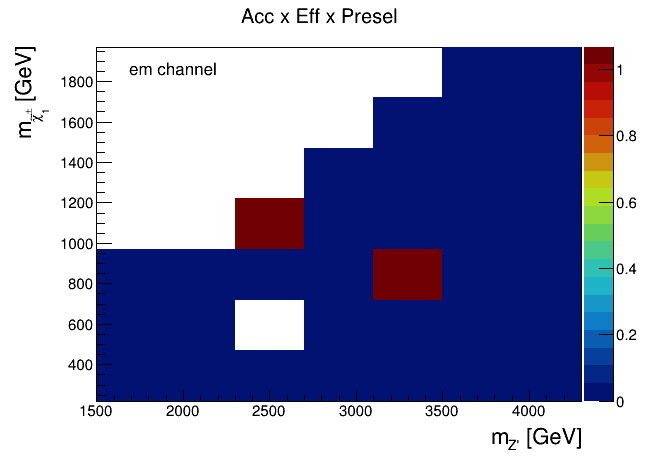

In [33]:
Zp_mass=[1700, 2100, 2500, 2900, 3300, 3700, 4100]
CH_mass=[345, 595, 845, 1095, 1345, 1595, 1845]
c1=rt.TCanvas("c1", "c1", 650, 500)
c1.SetLeftMargin(0.15)
c1.SetBottomMargin(0.15)
h2d1=rt.TH2D("h2d1", "", len(Zp_mass), Zp_mass[0]-200, Zp_mass[-1]+200, len(CH_mass), CH_mass[0]-125, CH_mass[-1]+125)
h2d1.SetTitle("Acc x Eff x Presel")

n_sig_in = 150000/4
if "em" in ERA:
    n_sig_in = 150000/2

for key in dic_df_raw:
    if not "Zp" in key:
        continue
    tmp=key.replace('_', '-')
    tmp=tmp.split('-')
    
    MZp=tmp[1]
    MCH=tmp[3]
    binx=Zp_mass.index(int(MZp))+1
    biny=CH_mass.index(int(MCH))+1
    h2d1.SetBinContent(binx, biny, dic_df_raw[key].shape[0]/(n_sig_in))
# missing bin by hand
h2d1.SetBinContent(5, 3, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000
h2d1.SetBinContent(3, 4, 40000/(n_sig_in)) #mumu: 23500, #ee: 20000

# set_palette("rainbow",255)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetPalette(55)

h2d1.Draw("colz")
h2d1.SetYTitle("m_{#tilde#chi_{1}^{#pm}} [GeV]")
h2d1.SetXTitle("m_{Z'} [GeV]")
h2d1.GetYaxis().SetTitleSize(0.05)
h2d1.GetXaxis().SetTitleSize(0.05)
latex=rt.TLatex()
latex.DrawLatexNDC( 0.2,0.84, "#scale[0.8]{#font[42]{"+"em channel}}")

c1.Draw()
c1.SaveAs("sigeff_"+ERA+".pdf")